# L'étude sur la pertinence des patterns de regexp dans la détection de NER tags et sur la distribution des NER tags dans les Wikipédias de fruits et d'entreprises

Ce travail consiste à explorer la faisabilité d'utiliser des patterns d'expressions régulières pour la tâche de détection de NER tags dans des textes anglais. Il cherche par ailleurs à évoquer la corrélation entre la longueur de texte et le nombre de NER tags, ainsi que la distribution des 3 NER tags (PERS pour personne, ORG pour organisation, LOC pour localisation) dans les pages Wikipédia de fruits et d'entreprises.

Les corpus recueillis sont tirés des sites de Wikipédia dont 15 sur différents fruits et 15 sur des entreprises informatiques. Les liens de chaque page de Wikipédia sont conservés dans deux fichiers .txt : "fruits.txt" pour les fruits et "companies.txt" pour les entreprises. Chaque lien est séparé par un retour à la ligne. Dans ce travail, nous allons utiliser les modules "requests" et "BeautifulSoup" pour accéder à chaque lien puis extraire les textes bruts. Comme le principe du travail est la détection de NER tags, nous souhaitons prendre les textes tels quels avec seulement l'enlèvement des signes d'annotation (comme [1] ou [2]).

Le contenu de chaque page de Wikipédia sera respectivement conservé dans une liste puis nous procédons à l'augmentation des données, ce qui donnera au total 30 textes pour chaque sujet. 80% des textes seront pris comme corpus d'entraînement.

Les corpus d'entraînement seront analysés par les patterns d'expressions régulières. À partir des résultats de prédiction des expressions régulières, nous extrayons les paires "nombre de tokens : nombre de tags détectés" pour chaque corpus dans deux dictionnaires (pour les fruits et les entreprises). Puis nous analysons la corrélation et la P-Value entre le nombre de tokens et le nombre de tags. L'analyse sera aussi présentée sous forme de graphes.

Par la suite, nous calculons la distribution des 3 NER tags dans le corpus de fruits et celui d'entreprises. Les résultats sont également présentés sous forme de graphes.

Le corpus de référence est disponible sur : https://huggingface.co/datasets/conll2003?row=0. Ce corpus traite plusieurs tâches, y compris la détection de POS tags, de Chunk tags et de NER tags. Nous reprenons ici seulement les résultats des NER tags. Nous le transformons d'abord en objet DataFrame, puis le concaténons avec nos propres corpus recueillis.

À l'étape de l'évaluation, nous analysons les mêmes corpus d'entraînement avec Spacy afin de fournir les résultats de référence. Ensuite, nous comparons les NER tags détectés par les expressions régulières et ceux par Spacy. Il faut noter que les patterns d'expressions régulières détectent souvent plusieurs NER tags pour un seul token. Nous avons décidé de sauvegarder tous les tags détectés. Les évaluations s'appuient sur la précision, le rappel et la f-mesure. Nous calculons d'abord ces 3 métriques pour chaque token, puis nous faisons la moyenne de ces mesures comme évaluations finales.

# Boîte à outil

In [1]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ast
import numpy as np
import requests
import pandas as pd
import datasets
from datasets import Dataset, concatenate_datasets, load_dataset
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from dataclasses import dataclass
import spacy
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
import re
import random
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
import scipy.stats
import nltk

/Users/zhongjie/miniconda3/envs/tal-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Classes

In [4]:
"""
Classe Token : représente un token avec son indice, sa forme et son tag NER.
- id : l'indice du token (commençant à 0).
- forme : la forme du token.
- ner_tag : le tag NER du token, représenté par un entier.

Classe Result : représente les résultats d'analyse groupés avec leur index et le nombre total de tokens.
- id : l'index du corpus (commençant à 1).
- datas : une liste de toutes les phrases analysées.
- length : le nombre total de tokens dans le corpus.
"""
@dataclass
class Token:
    id: str
    forme: str
    ner_tag: list

@dataclass
class Result:
    id: int
    datas: list
    length: int


# Formation des corpus

In [5]:
def recup_web(url: str) -> str:
    """
    Cette fonction récupère le contenu textuel brut d'un site Internet et le retourne.

    Args:
        url (str): L'URL du site sous forme de chaîne de caractères.

    Returns:
        str: Le contenu textuel brut du site.
    """
    # Effectue une requête GET pour obtenir le contenu du site
    reponse = requests.get(url)

    contenu_html = ""

    # Vérifie le code de réponse
    if reponse.status_code == 200:
        # Si le code de réponse est 200 (OK), copie le contenu textuel dans "contenu_html"
        contenu_html = reponse.text
    elif reponse.status_code == 300:
        # Si le code de réponse est 300 (Redirection), poursuit la redirection et copie le contenu final dans "contenu_html" si le code de réponse est 200
        url_final = reponse.url
        reponse_finale = requests.get(url_final)
        if reponse_finale.status_code == 200:
            contenu_html = reponse_finale.text
    else:
        # Si le code de réponse n'est ni 200 ni 300, affiche "Site inachevable"
        print("Site inachevable")

    return contenu_html

def html_parser(contenu_html: str) -> str:
    """
    Cette fonction analyse le contenu textuel récupéré à l'aide de BeautifulSoup, 
    puis retourne les textes présents dans les balises <p>.

    Args:
        contenu_html (str): Le texte brut d'un site Internet, correctement formaté selon la syntaxe HTML.

    Returns:
        str: Les textes extraits des balises <p> sous forme d'une seule chaîne de caractères.
    """
    # Parseur HTML
    soup = BeautifulSoup(contenu_html, 'html.parser')

    corpus = ""

    # Recherche toutes les balises <p> et ajoute leur contenu à "corpus"
    for balise in soup.find_all("p", recursive=True):
        if balise.text.strip(): 
            corpus += balise.text.strip() + "\n" 

    return corpus

In [6]:
# Chemins vers les fichiers contenant les URLs des fruits et des entreprises.
path_fruits = "../../src/fruits.txt"
path_companies = "../../src/companies.txt"

# Ouvrir le fichier d'URLs des fruits
with open(path_fruits, 'r', encoding='utf-8') as file:
    fruits_urls = file.readlines()

# Récupération du contenu HTML pour les sites de fruits
corpus_fruits = [] # Le texte brut de chaque site sera stocké dans une liste
for idx, url in enumerate(fruits_urls):
    url = url.strip()
    # Récupération du contenu HTML du site et suppression des nombres entre crochets [1], [10], [22] etc.
    contenu_html = recup_web(url)
    texte_sans_nombres = re.sub(r"\[\d+\]", "", contenu_html)
    texte_nettoye = html_parser(texte_sans_nombres)
    corpus_fruits.append(texte_nettoye)
    
    # Exporter le corpus brut
    with open(f'../../data/raw/{idx+1}_fruit.txt', 'w', encoding='utf-8') as file:
        file.write(texte_sans_nombres)
    # Exporter le corpus nettoyé
    with open(f'../../data/clean/{idx+1}_fruit.txt', 'w', encoding='utf-8') as file:
        file.write(texte_nettoye)

# La même procédure pour les sites d'entreprises
with open(path_companies, 'r', encoding='utf-8') as file:
    companies_urls = file.readlines()

corpus_companies = []
for idx, url in enumerate(companies_urls):
    url = url.strip()
    # Récupération du contenu HTML du site et suppression des nombres entre crochets [1], [10], [22] etc.
    contenu_html = recup_web(url)
    texte_sans_nombres = re.sub(r"\[\d+\]", "", contenu_html)
    texte_nettoye = html_parser(texte_sans_nombres)
    corpus_companies.append(texte_nettoye)
    
    # Exporter le corpus brut
    with open(f'../../data/raw/{idx+1}_companie.txt', 'w', encoding='utf-8') as file:
        file.write(texte_sans_nombres)
    # Exporter le corpus nettoyé
    with open(f'../../data/clean/{idx+1}_companie.txt', 'w', encoding='utf-8') as file:
        file.write(texte_nettoye)

## Augmentation des données

In [7]:
# Concaténer les deux corpus
corpus_combined = corpus_fruits + corpus_companies

# Vectorisation des textes
vectorizer = TfidfVectorizer()  # Utilisez TF-IDF pour la vectorisation
X = vectorizer.fit_transform(corpus_combined)

# Les étiquettes pour l'augmentation des données
y = np.concatenate((np.zeros(len(corpus_fruits)), np.ones(len(corpus_companies))))

# Augmentation des données aléatoires
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Récupération des indices des échantillons après l'enrechissement des données
indices_resampled = ros.sample_indices_

# Sélectionner les données correspondantes dans les corpus d'origine
X_resampled_corpus = [corpus_combined[i] for i in indices_resampled]
y_resampled_labels = [y[i] for i in indices_resampled]

# Séparer les échantillons en fonction de leurs classes
X_resampled_fruits = [X_resampled_corpus[i] for i in range(len(X_resampled_corpus)) if y_resampled_labels[i] == 0]
X_resampled_companies = [X_resampled_corpus[i] for i in range(len(X_resampled_corpus)) if y_resampled_labels[i] == 1]

# Concaténer les échantillons enrichis avec les corpus d'origine
corpus_fruits.extend(X_resampled_fruits)
corpus_companies.extend(X_resampled_companies)

# Afficher la taille des corpus enrichis
print("Nombre de documents pour les fruits après l'augmentation :", len(corpus_fruits))
print("Nombre de documents pour les entreprises après l'augmentation :", len(corpus_companies))


Nombre de documents pour les fruits après l'augmentation : 30
Nombre de documents pour les entreprises après l'augmentation : 30


In [8]:
random.seed(42)

# Échantilloner 80% des corpus comme le corpus d'entraînement, puis 20% comme le corpus de test
train_fruits = random.sample(corpus_fruits, int(len(corpus_fruits) * 0.8))
train_companies = random.sample(corpus_companies, int(len(corpus_companies) * 0.8))

# Construire un compteur pour chaque corpus dans train_fruits
train_fruits_counter = Counter(train_fruits)
train_companies_counter = Counter(train_companies)

# Construire les corpus restants en retirant un exemplaire de chaque corpus trouvé dans train_fruits
test_fruits = []
test_companies = []

for corpus in corpus_fruits:
    if train_fruits_counter[corpus] > 0:
        train_fruits_counter[corpus] -= 1
    else:
        test_fruits.append(corpus)

for corpus in corpus_companies:
    if train_companies_counter[corpus] > 0:
        train_companies_counter[corpus] -= 1
    else:
        test_companies.append(corpus)

print("Le nombre des corpus d'entraînement pour fruits et entreprises : ", len(train_fruits), len(train_companies))
print("Le nombre des corpus de test pour fruits et entreprises : ",len(test_fruits), len(test_companies))

Le nombre des corpus d'entraînement pour fruits et entreprises :  24 24
Le nombre des corpus de test pour fruits et entreprises :  6 6


## Visualisation des corpus recueillis tels quels

In [9]:
# Un texte du corpus de fruits
display(corpus_fruits[0])

'An apple is a round, edible fruit produced by an apple tree (Malus spp., among them the domestic or orchard apple; Malus domestica). Apple trees are cultivated worldwide and are the most widely grown species in the genus Malus. The tree originated in Central Asia, where its wild ancestor, Malus sieversii, is still found. Apples have been grown for thousands of years in Eurasia and were introduced to North America by European colonists. Apples have religious and mythological significance in many cultures, including Norse, Greek, and European Christian tradition.\nApples grown from seed tend to be very different from those of their parents, and the resultant fruit frequently lacks desired characteristics. For commercial purposes, including botanical evaluation, apple cultivars are propagated by clonal grafting onto rootstocks. Apple trees grown without rootstocks tend to be larger and much slower to fruit after planting. Rootstocks are used to control the speed of growth and the size of

In [10]:
# Un texte du corpus d'entreprises
display(corpus_companies[0])

'Apple Inc. (formerly Apple Computer, Inc.) is an American multinational corporation and technology company headquartered in Cupertino, California, in Silicon Valley. It designs, develops, and sells consumer electronics, computer software, and online services. Devices include the iPhone, iPad, Mac, Apple Watch, Vision Pro, and Apple TV; operating systems include iOS, iPadOS, and macOS; and software applications and services include iTunes, iCloud, Apple Music, and Apple TV+.\nFor most of 2011 to 2024, Apple became the world\'s largest company by market capitalization until Microsoft assumed the position in January 2024.[6][7] In 2022, Apple was the largest technology company by revenue, with US$394.3\xa0billion.[8][failed verification] As of 2023[update], Apple was the fourth-largest personal computer vendor by unit sales,[9] the largest manufacturing company by revenue, and the largest vendor of mobile phones in the world.[10] It is one of the Big Five American information technology 

## Visualisation des corpus recueillis avec la loi de zipf

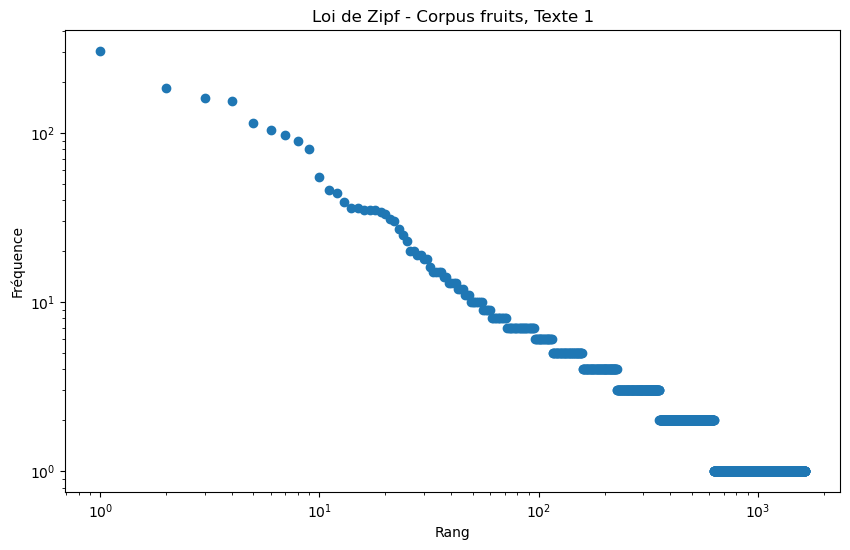

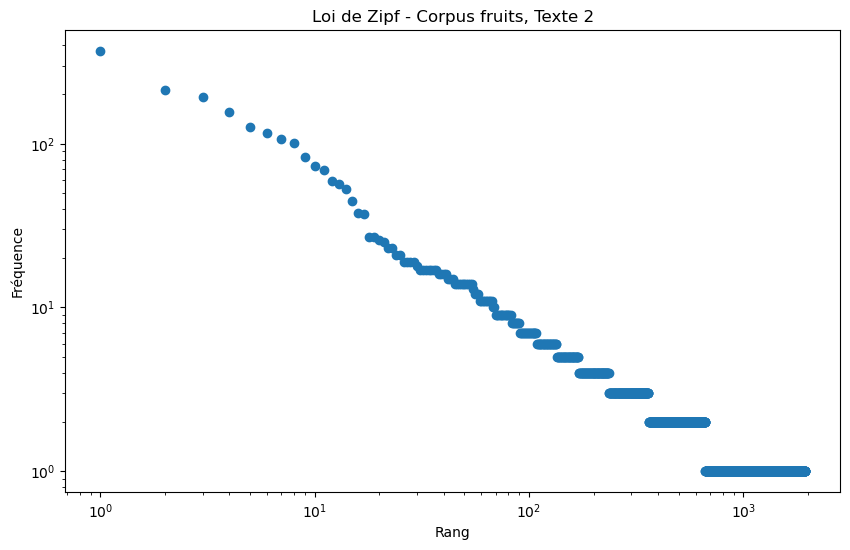

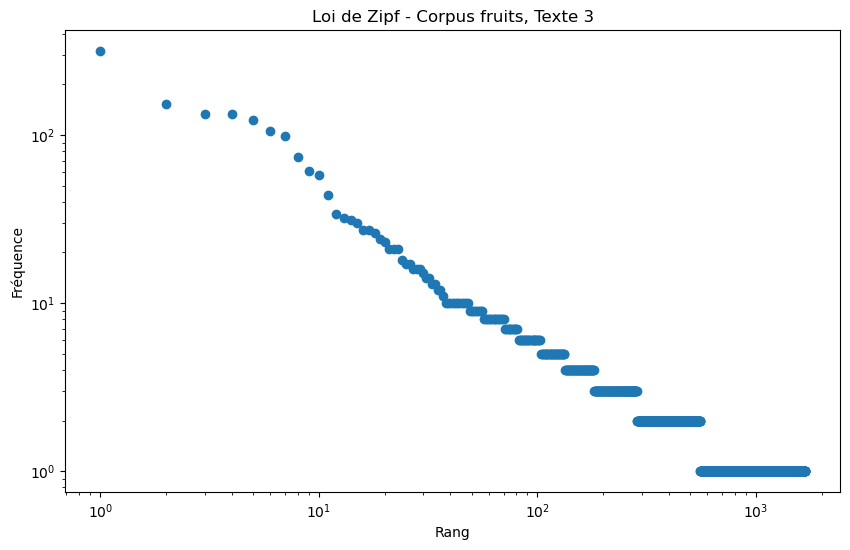

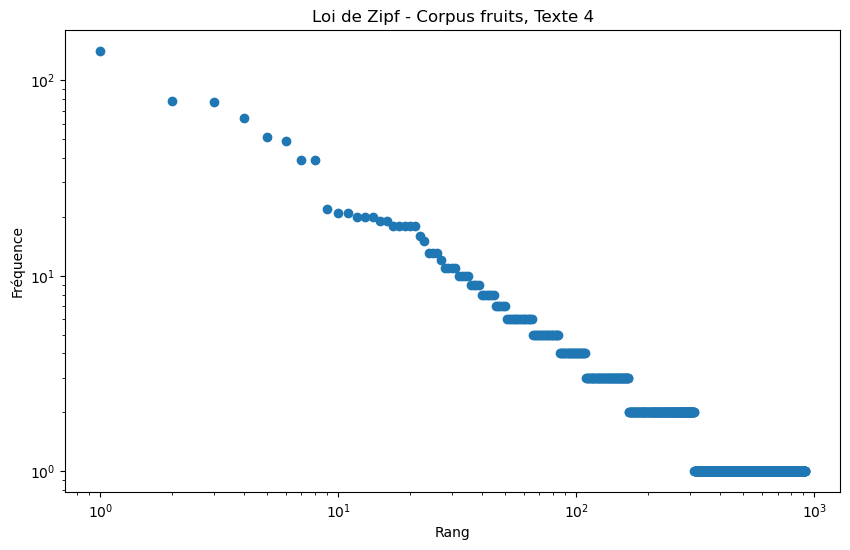

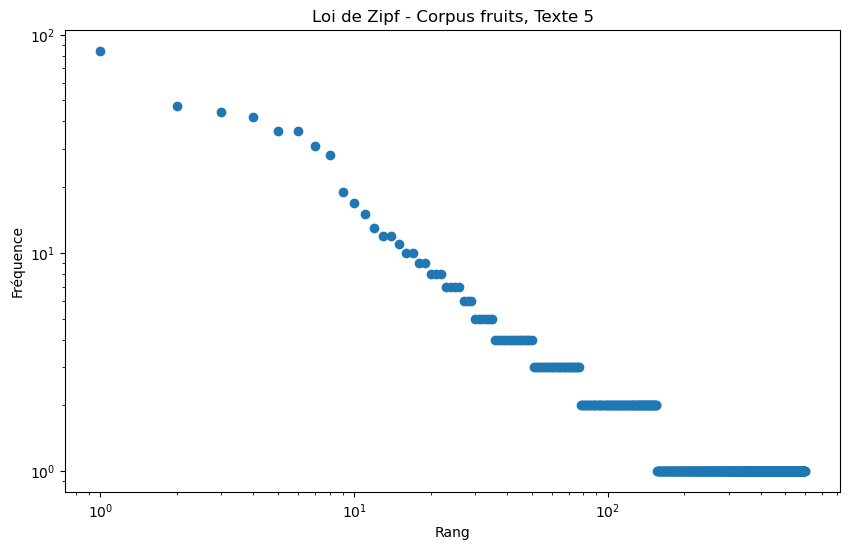

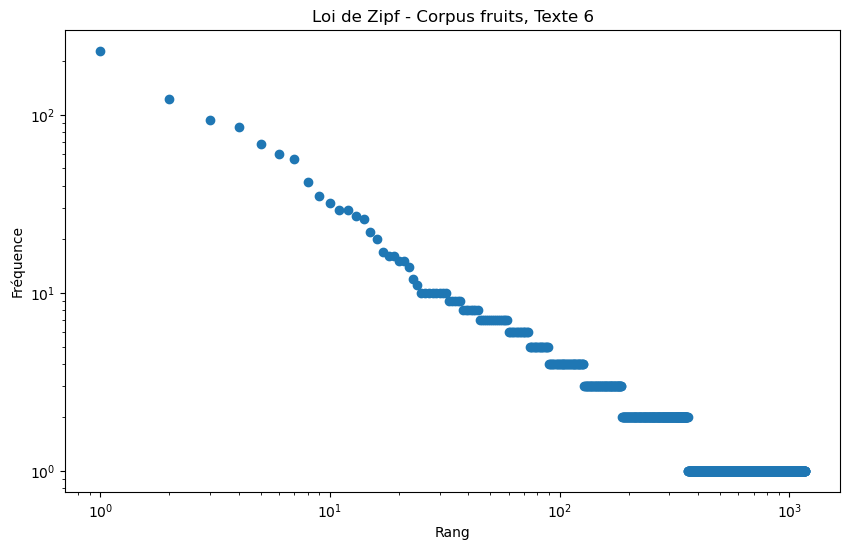

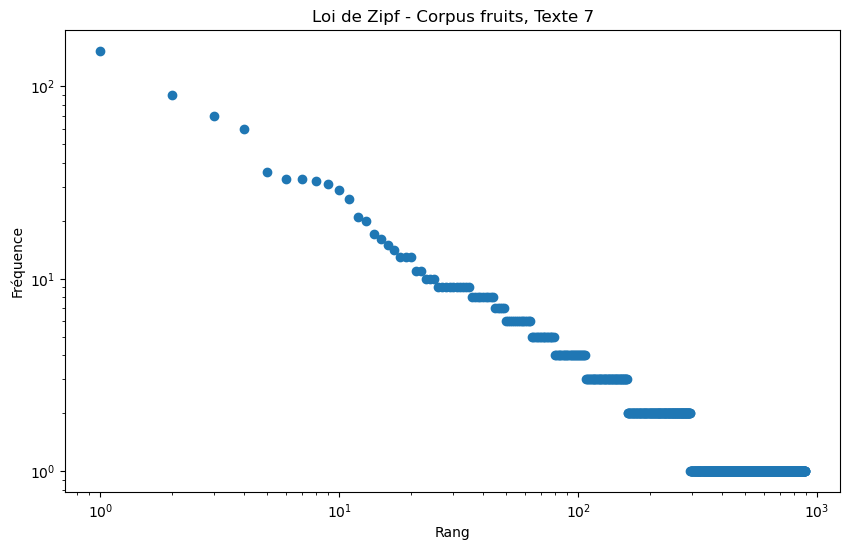

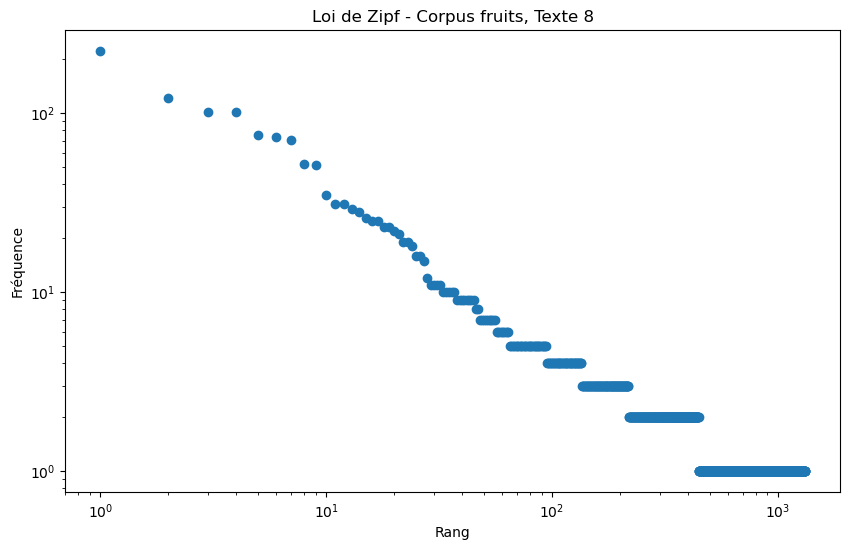

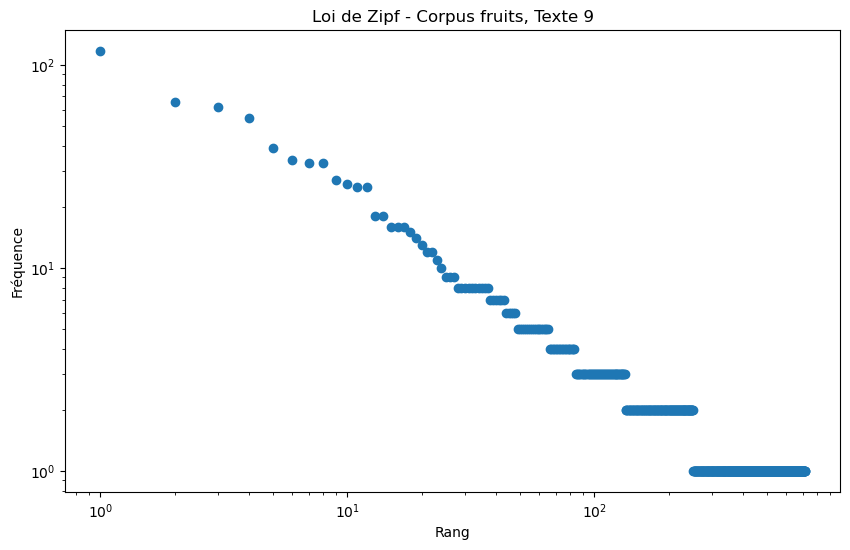

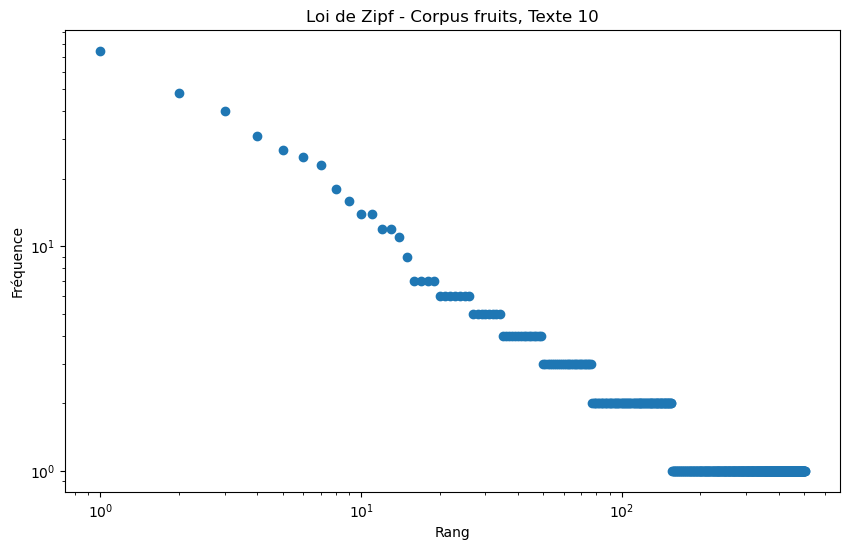

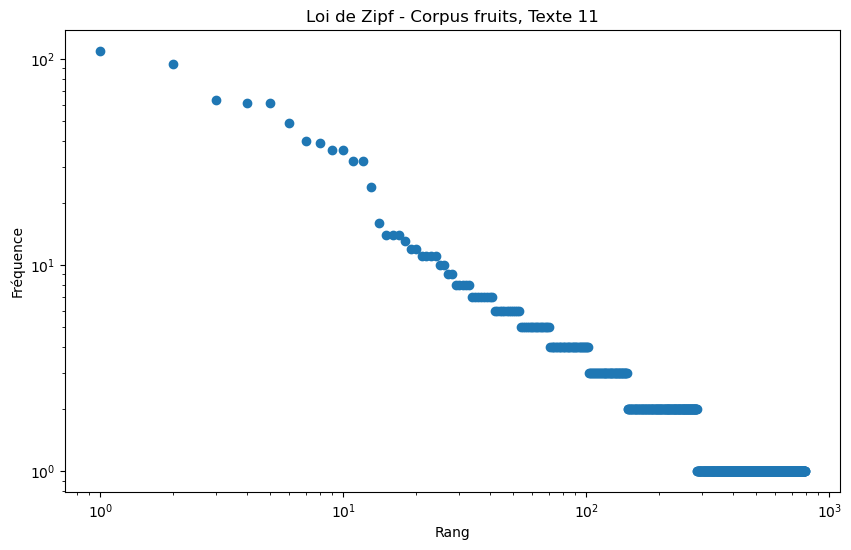

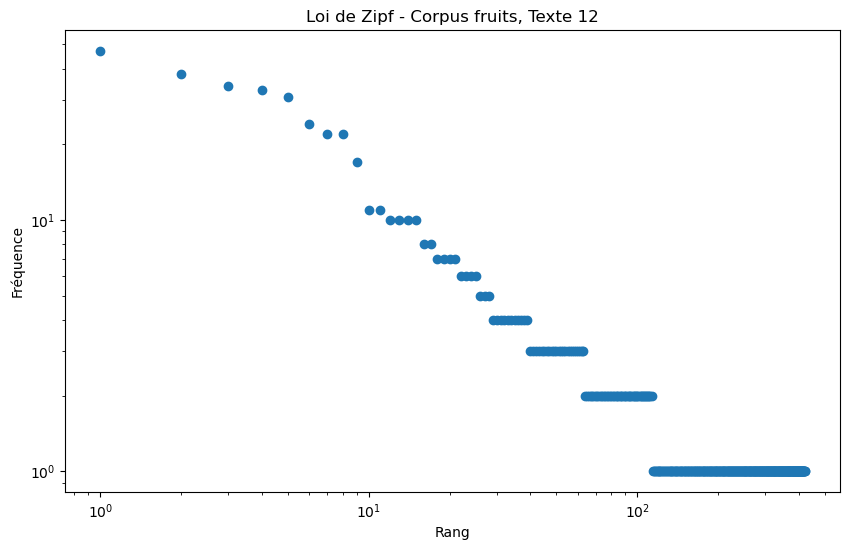

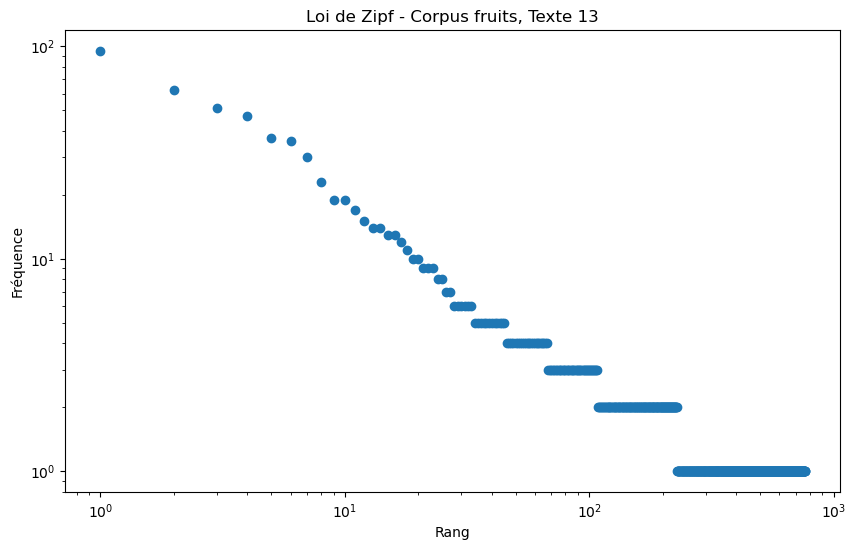

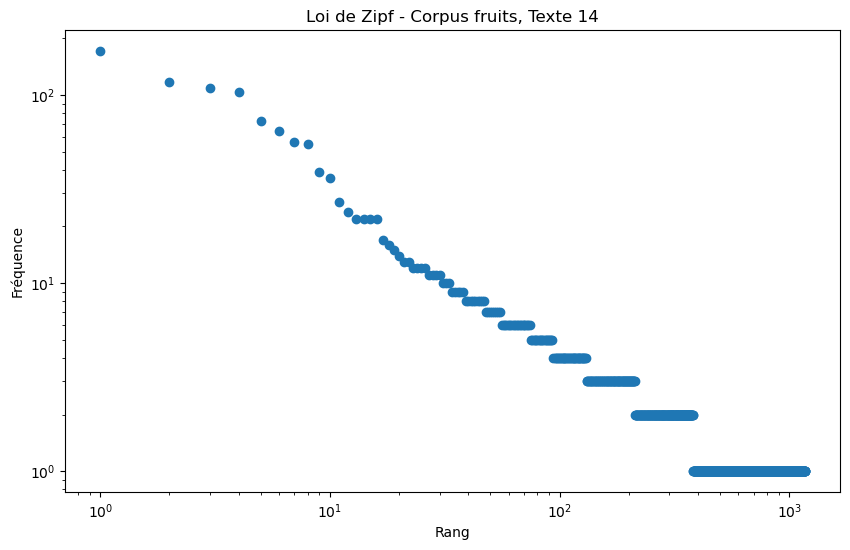

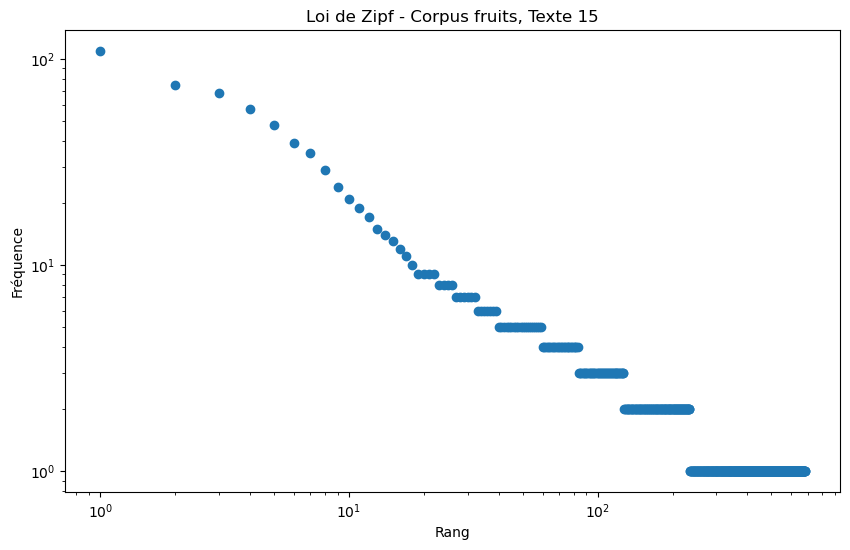

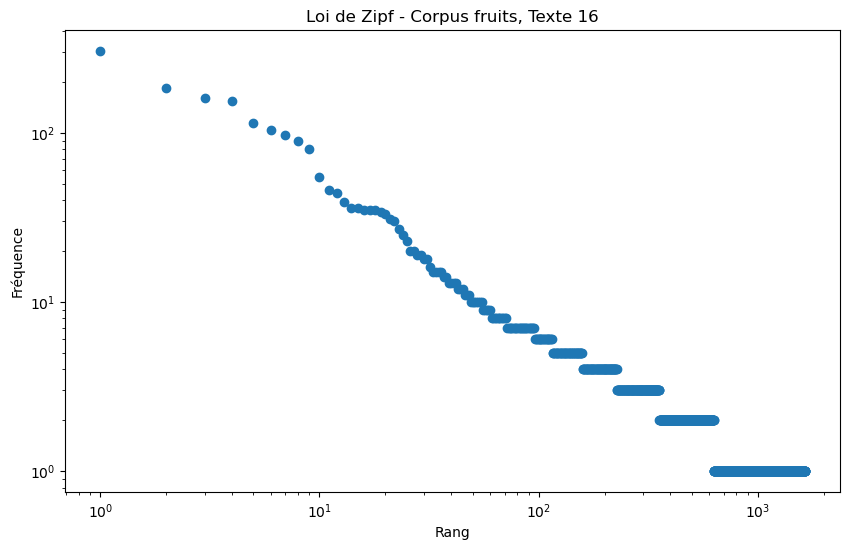

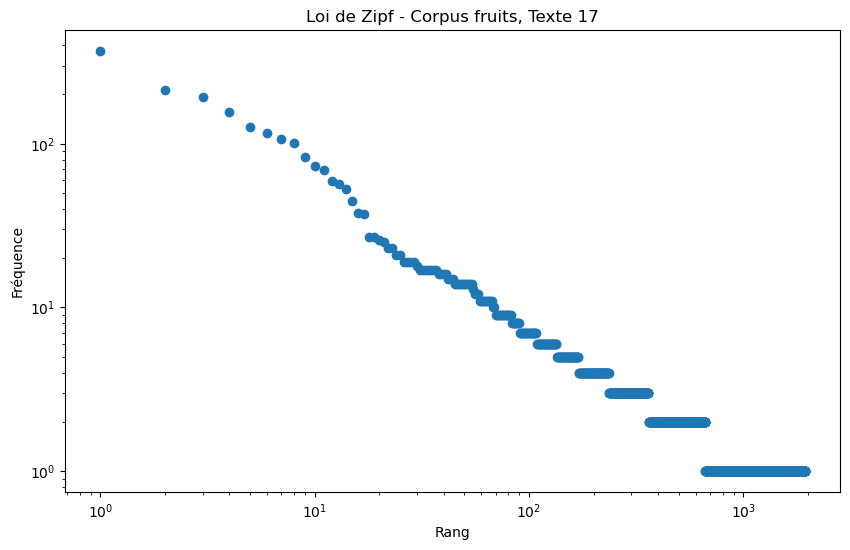

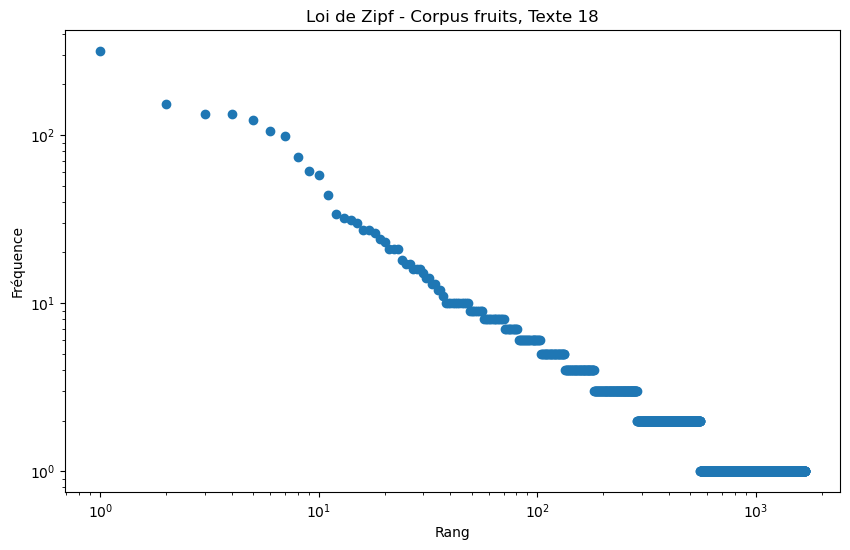

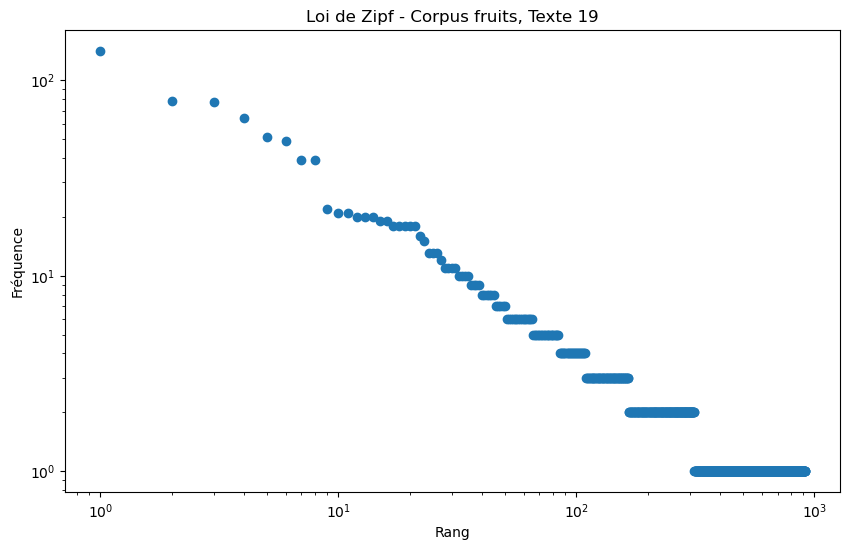

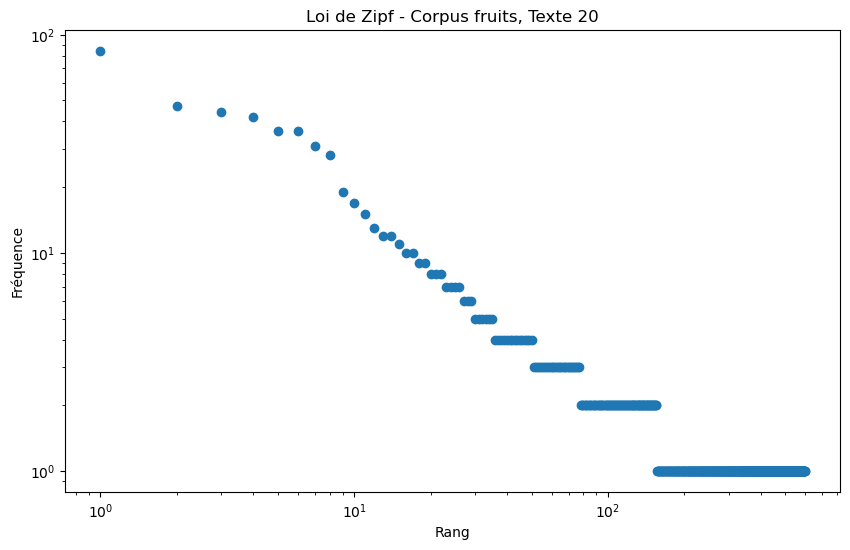

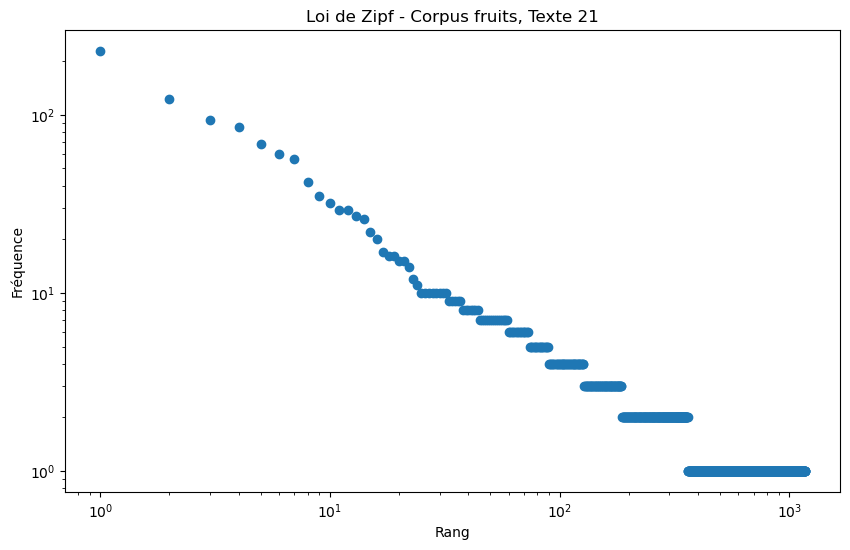

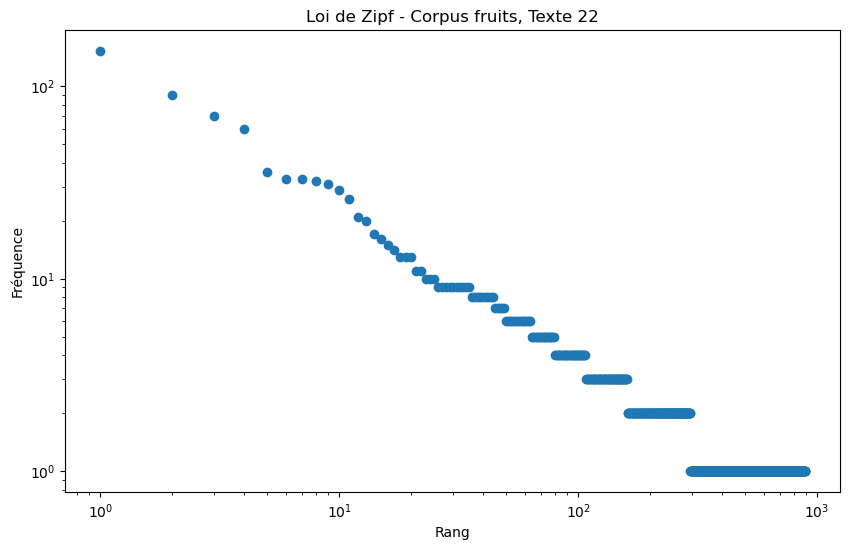

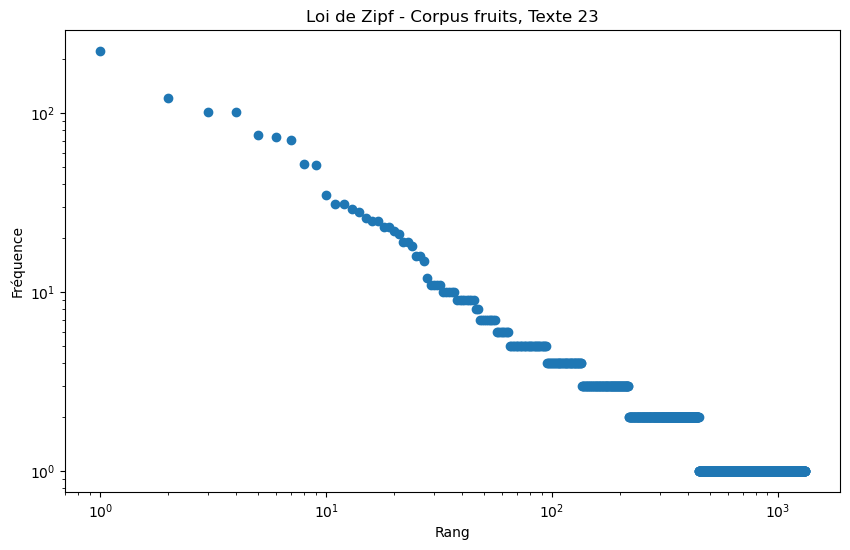

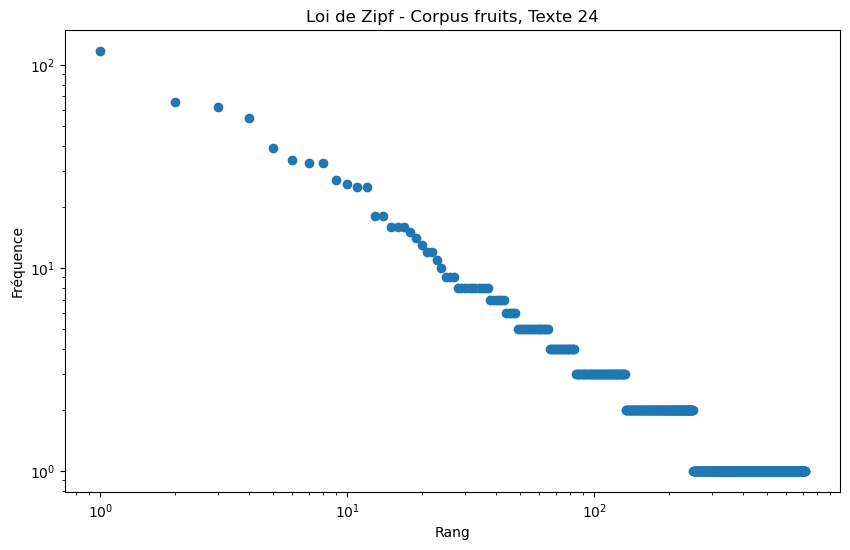

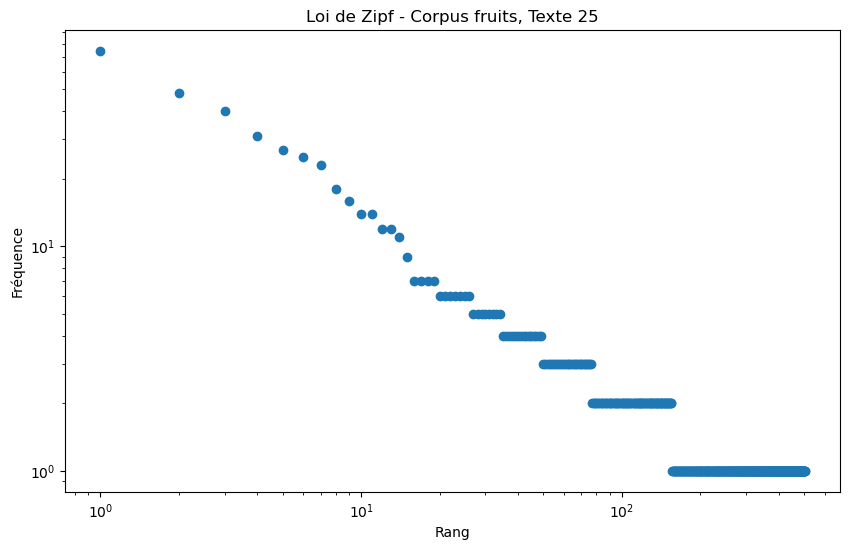

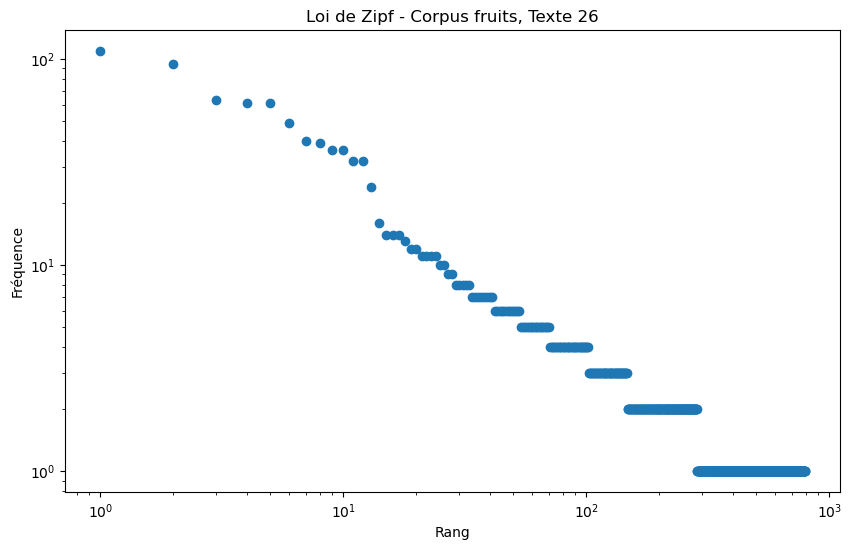

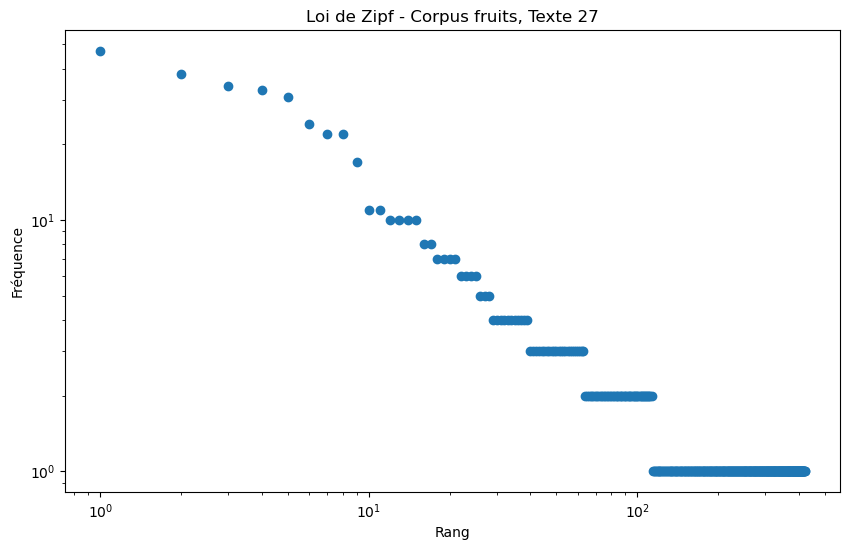

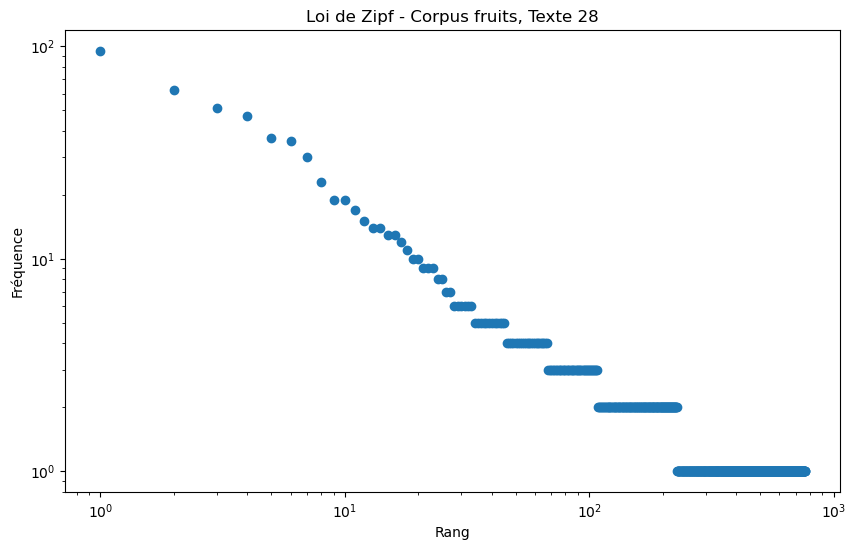

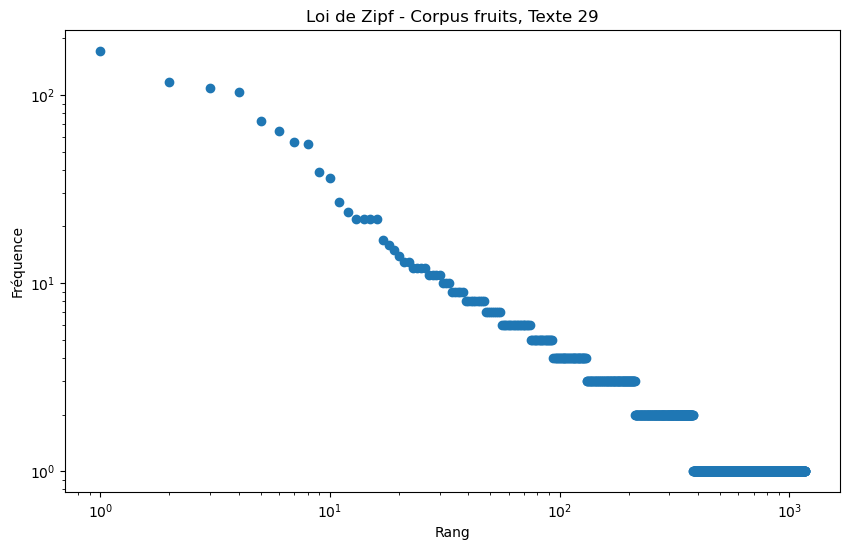

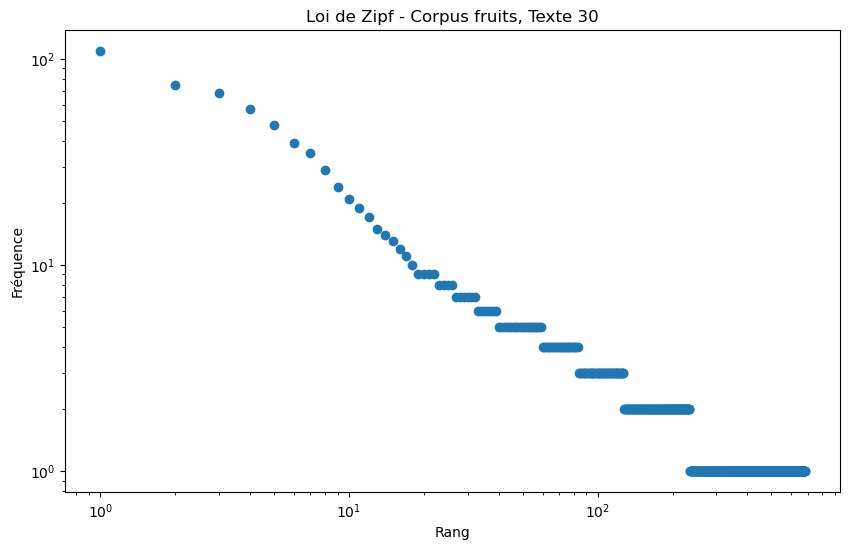

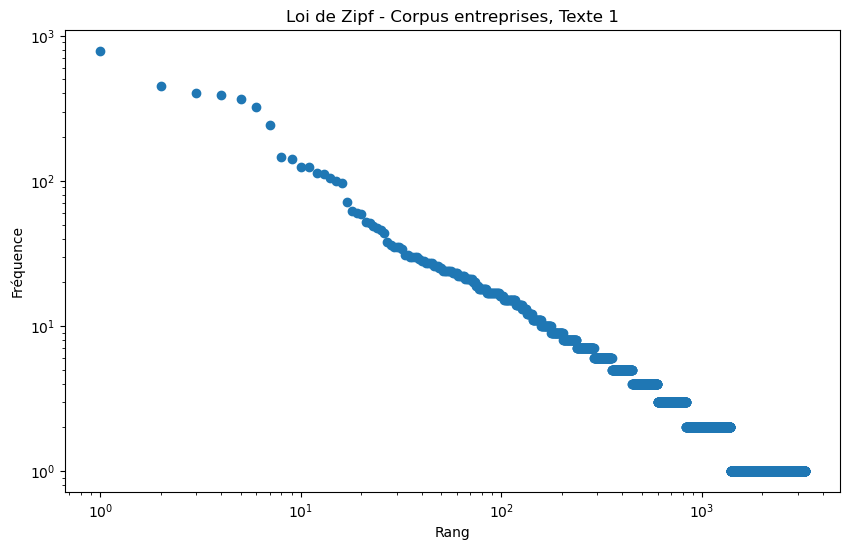

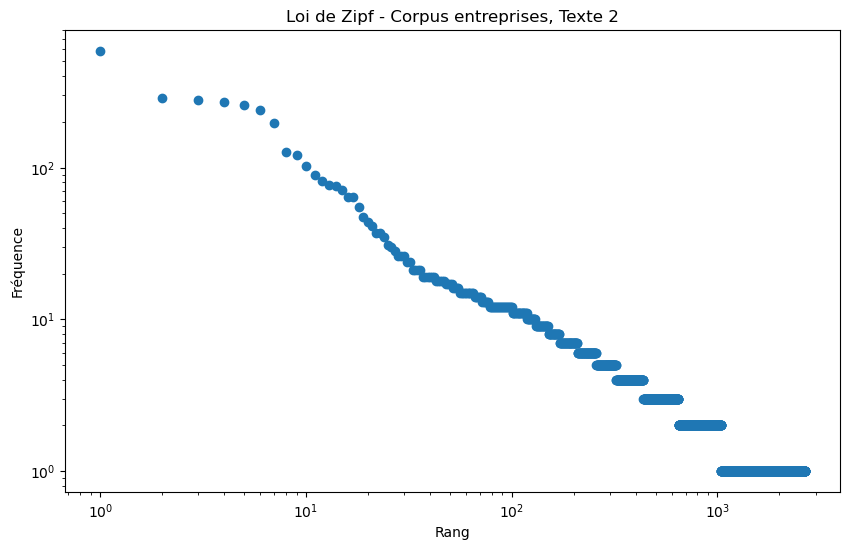

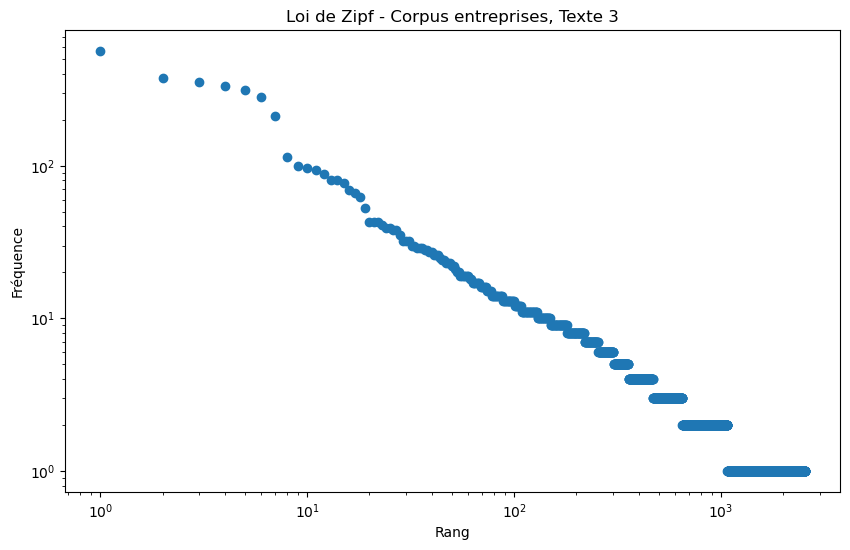

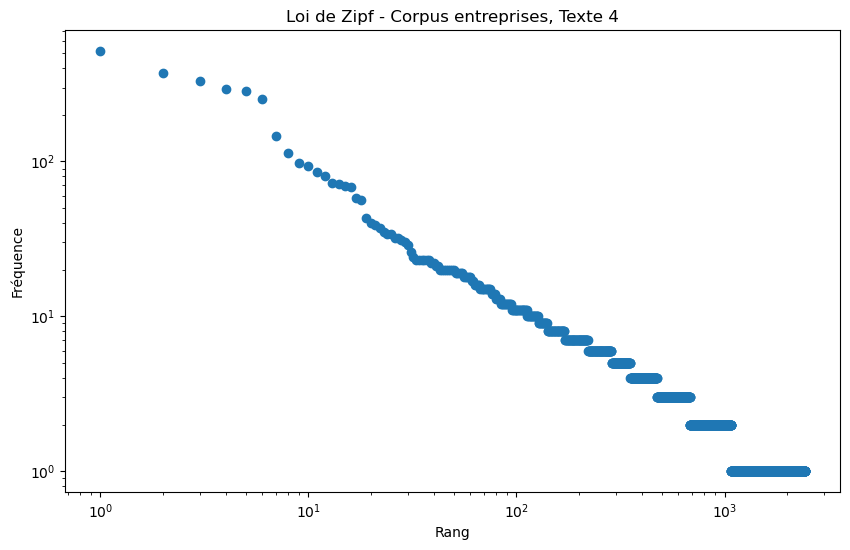

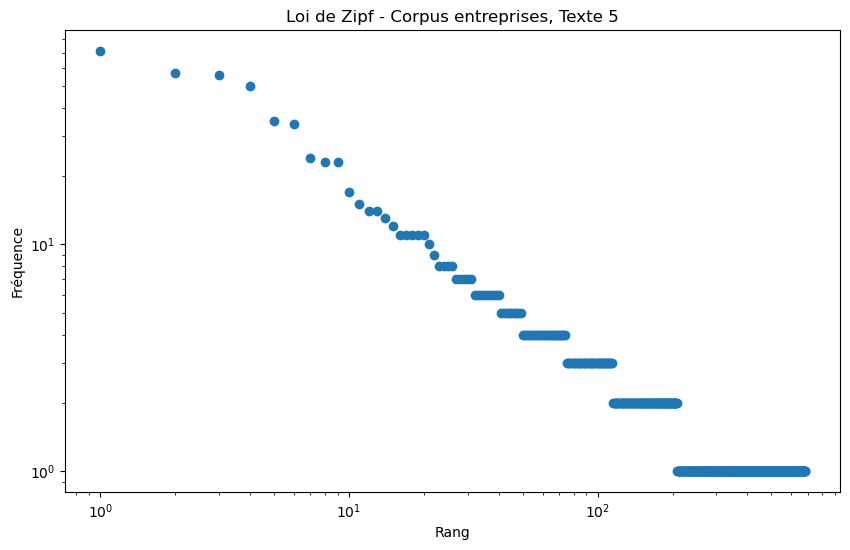

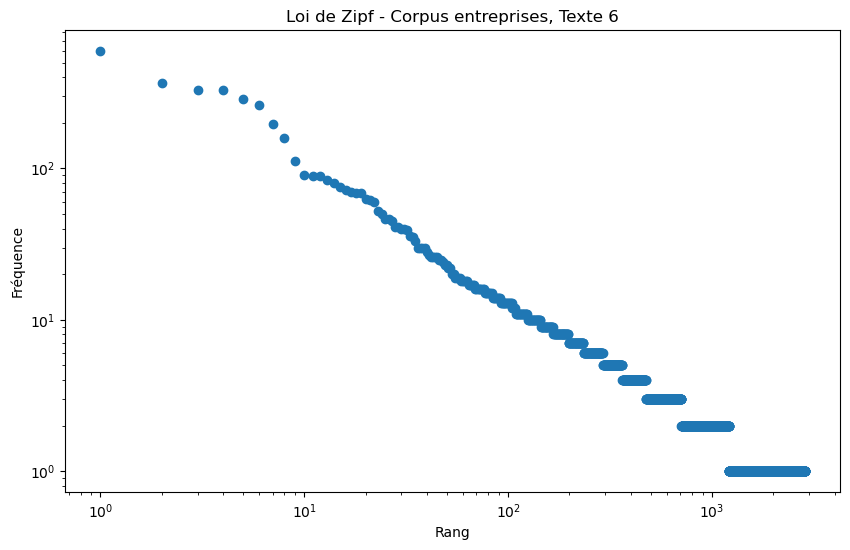

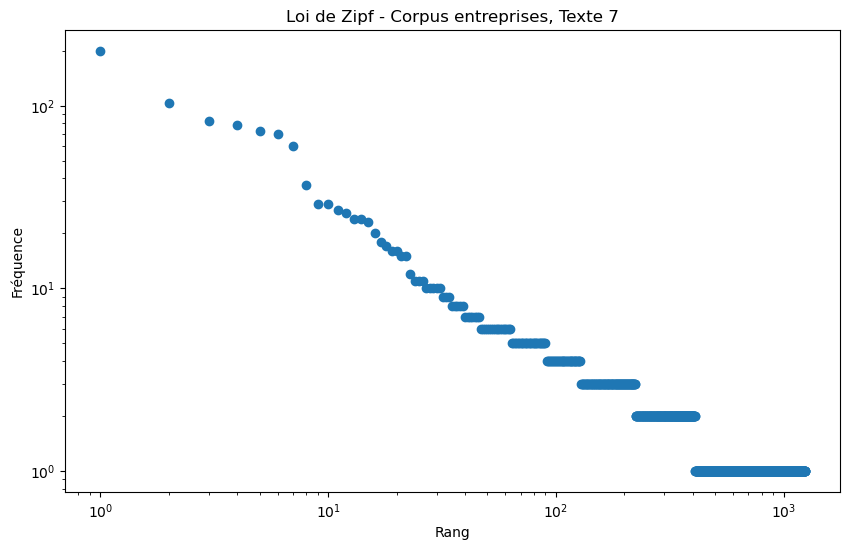

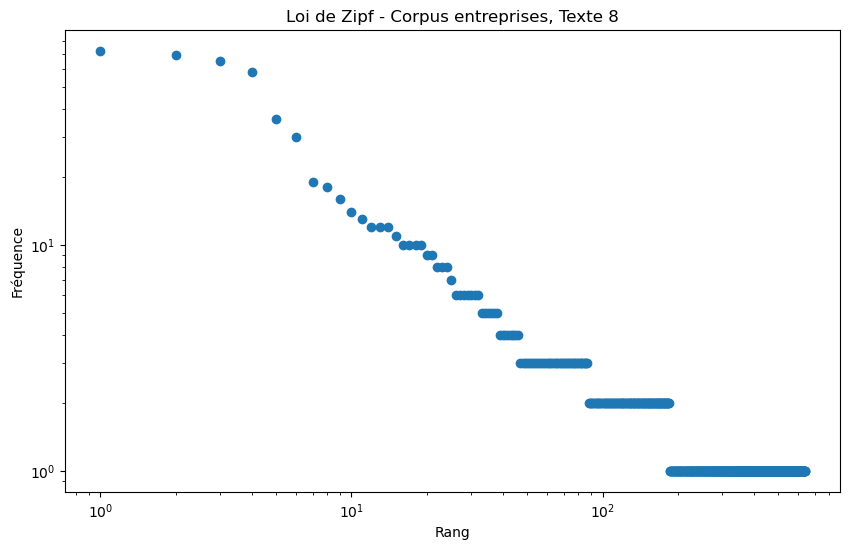

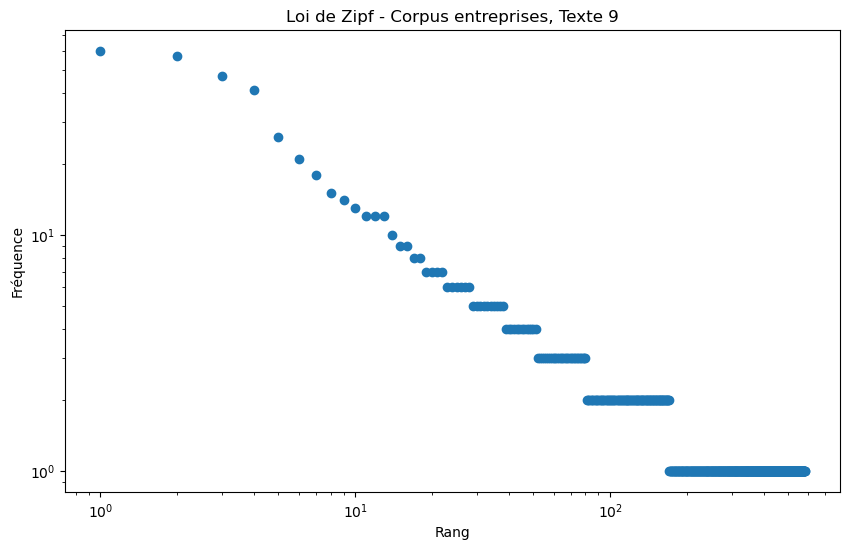

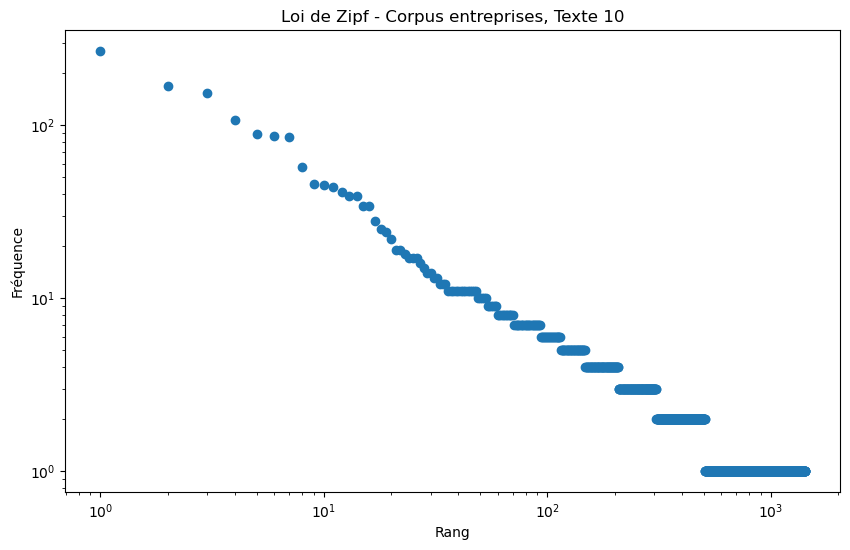

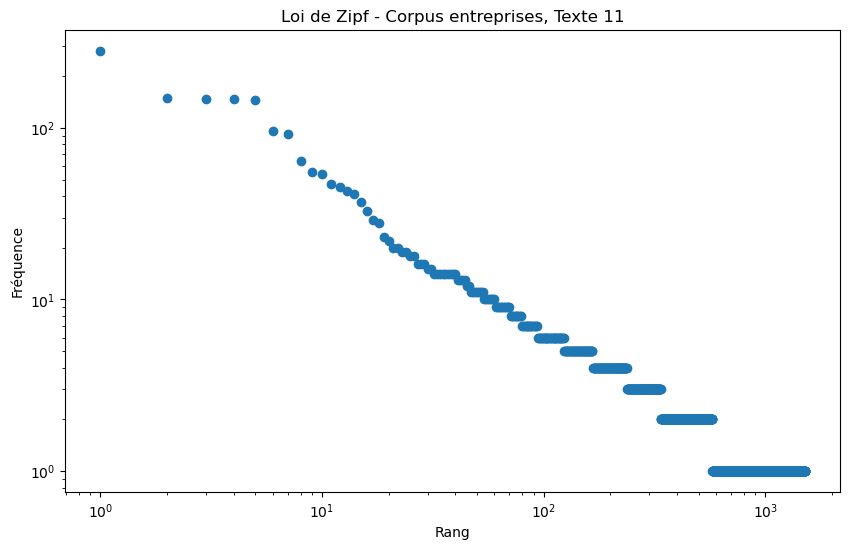

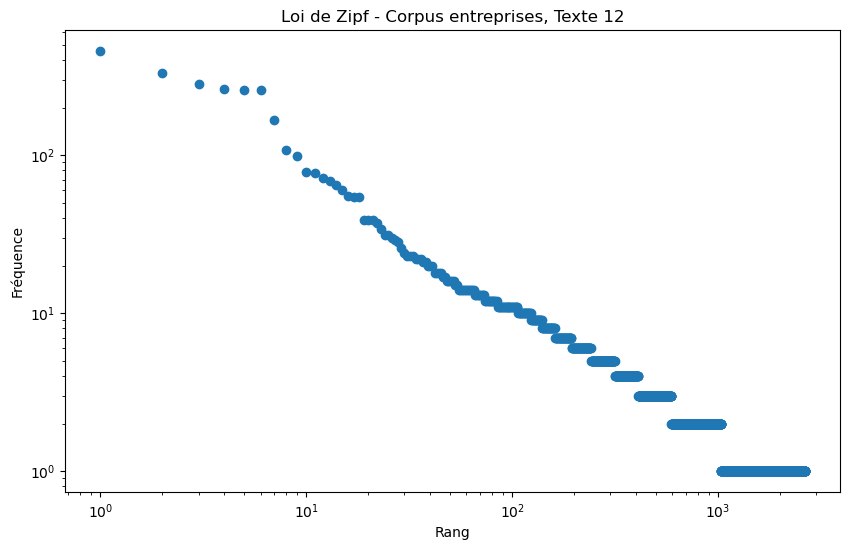

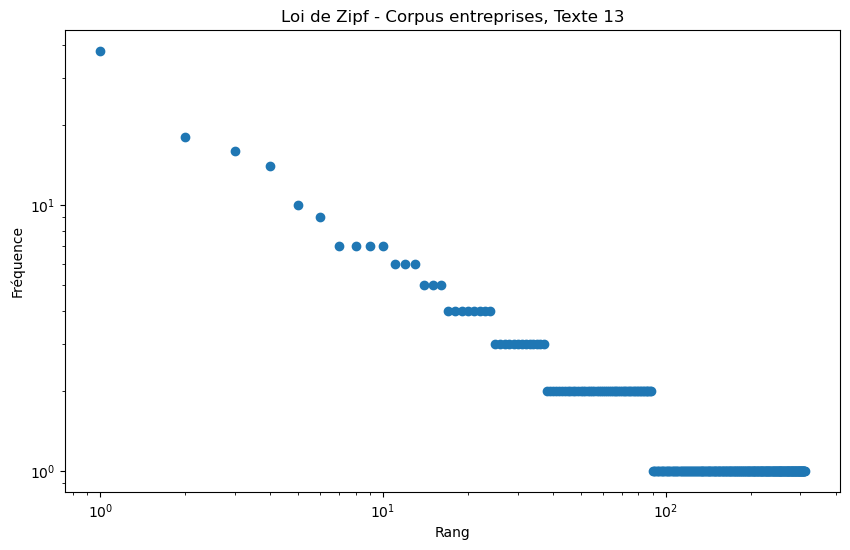

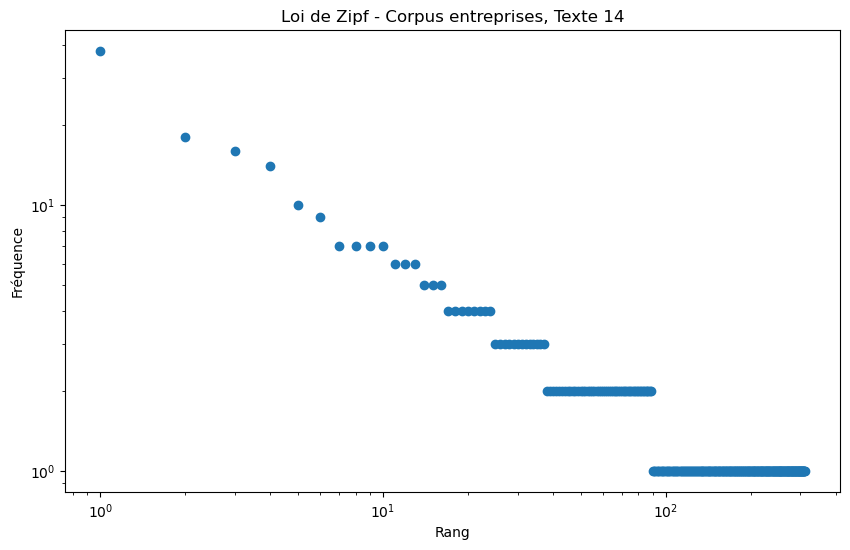

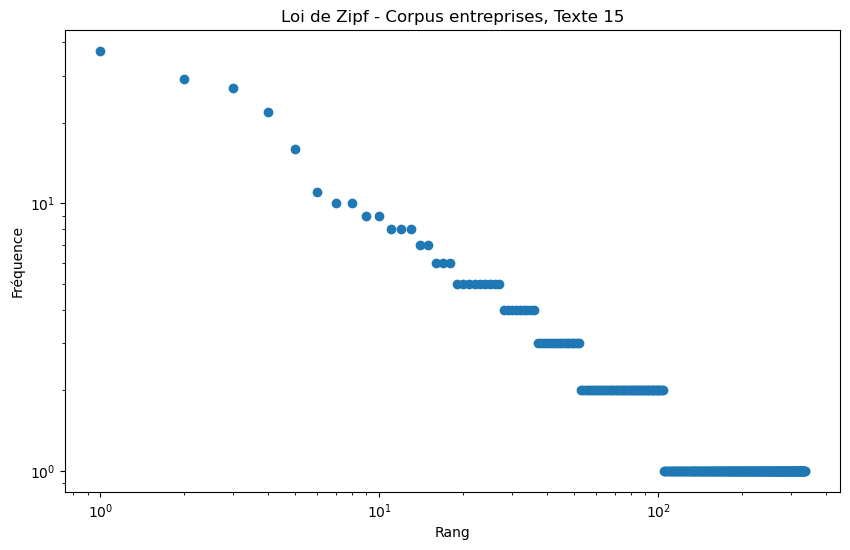

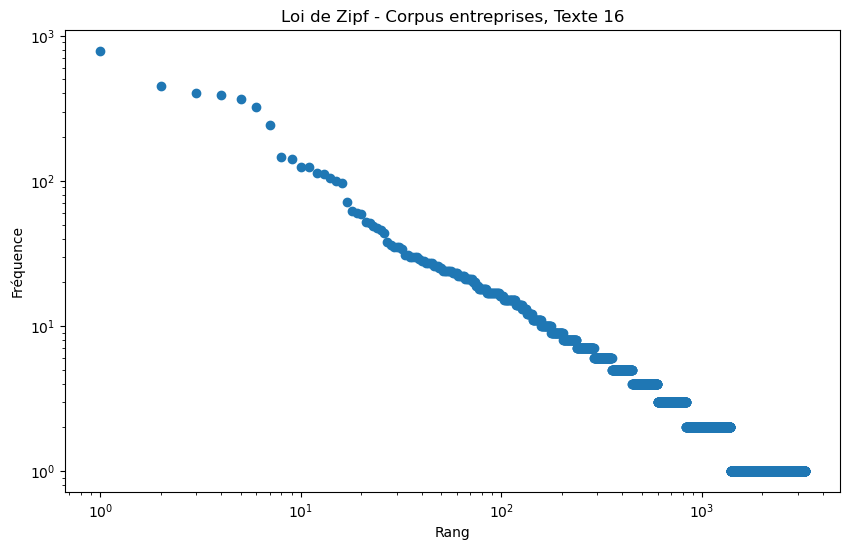

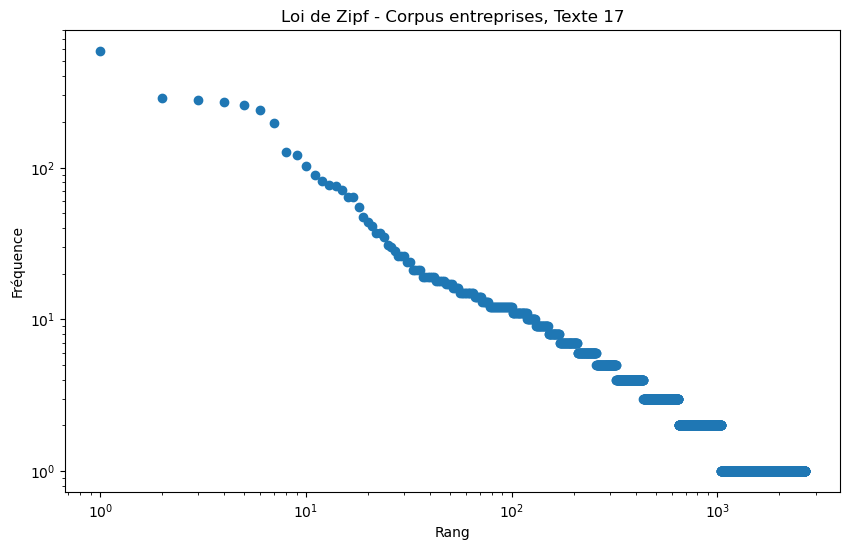

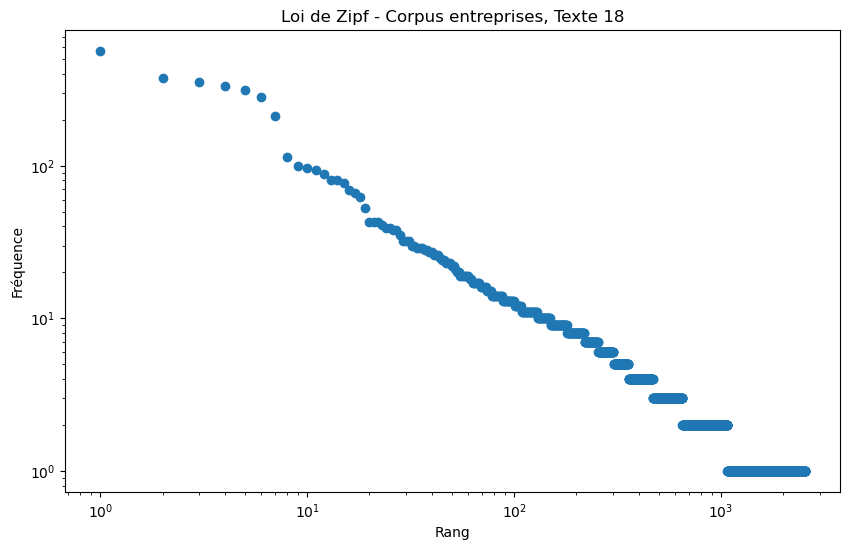

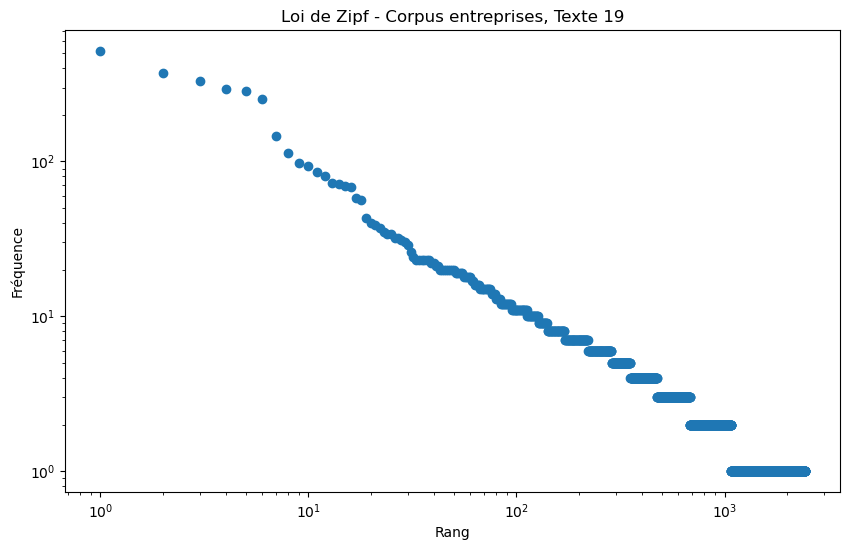

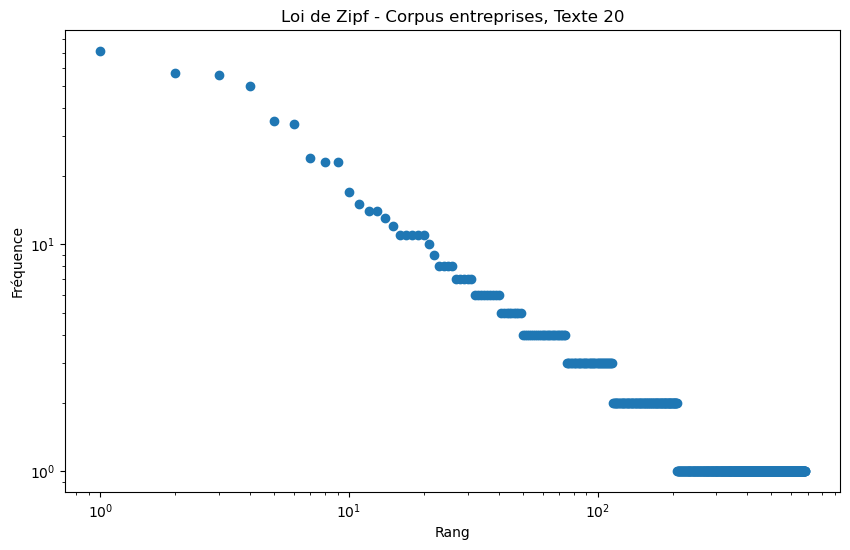

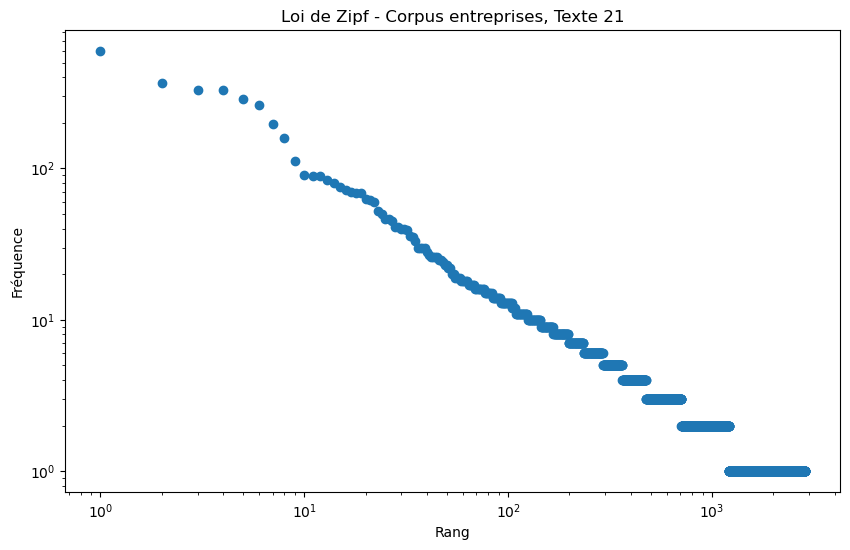

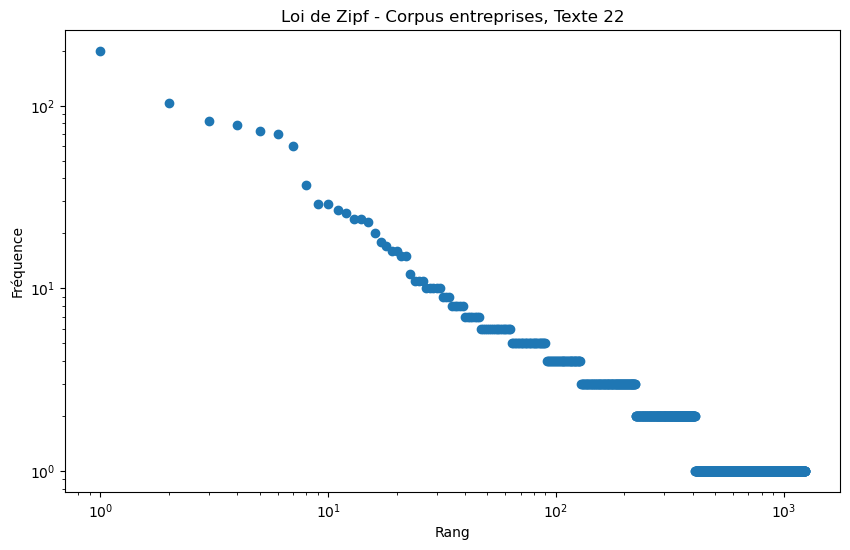

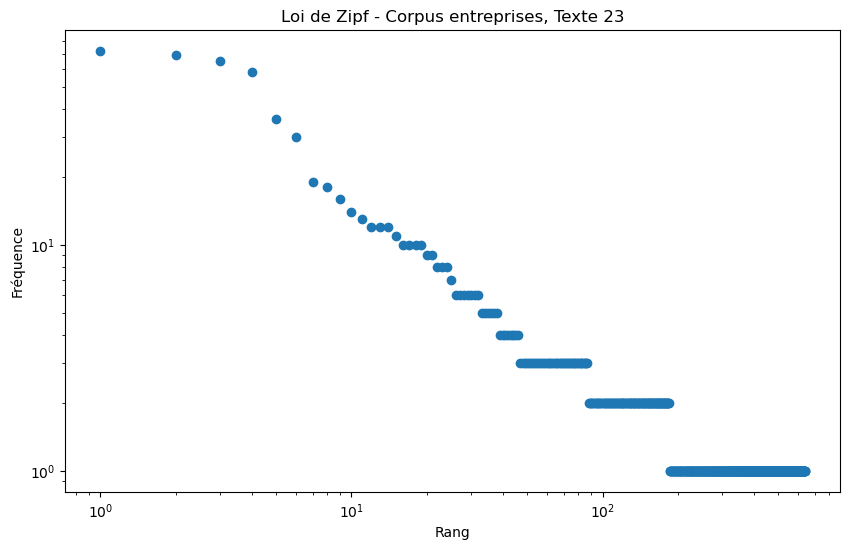

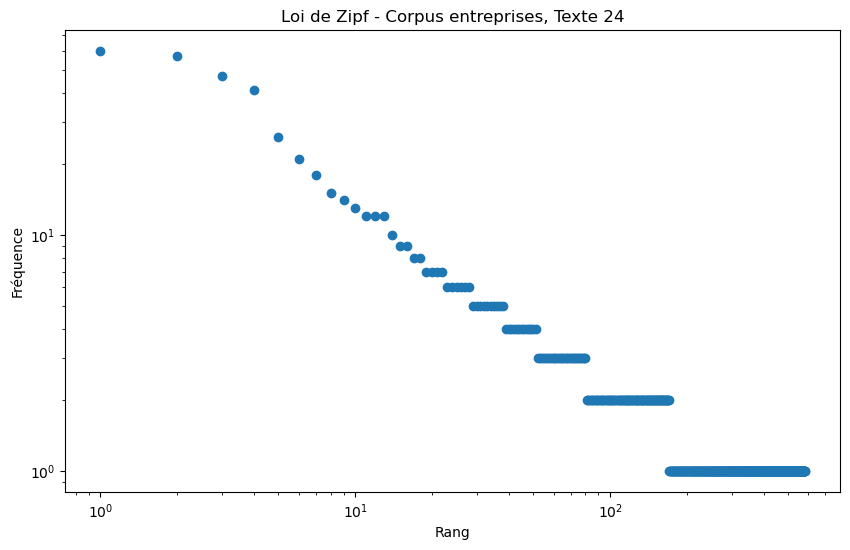

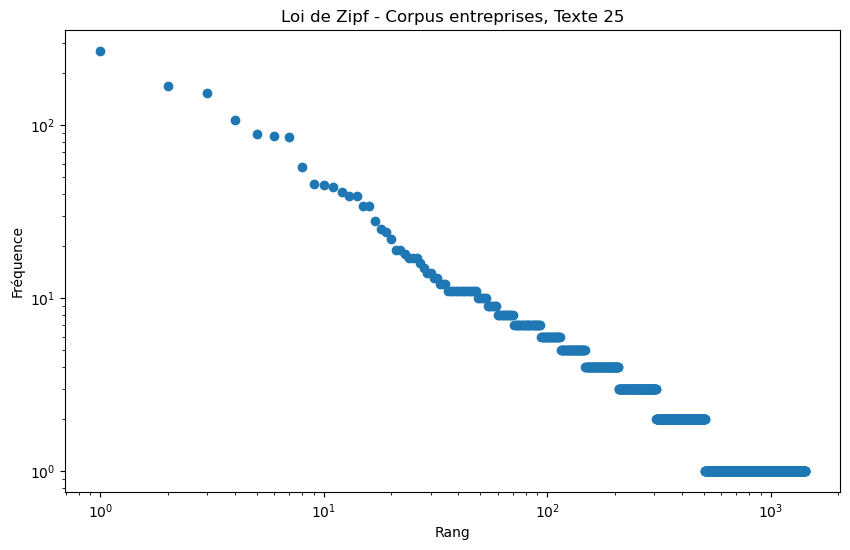

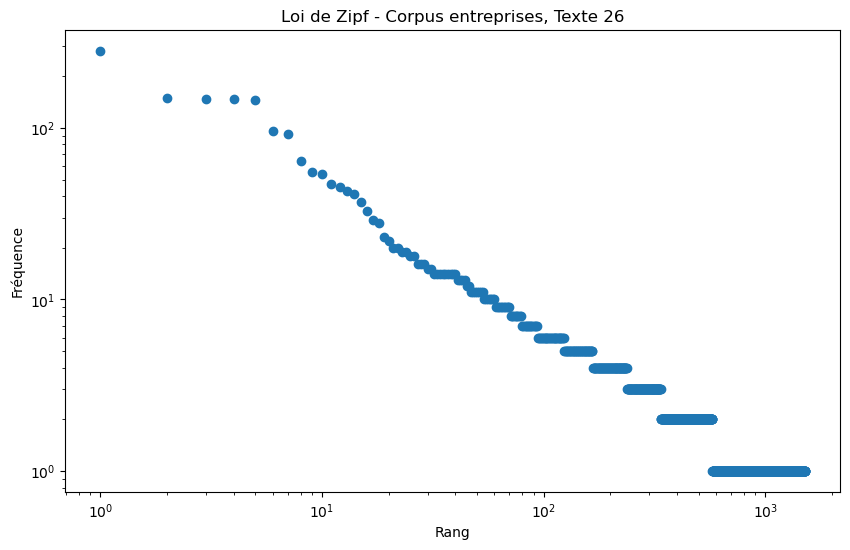

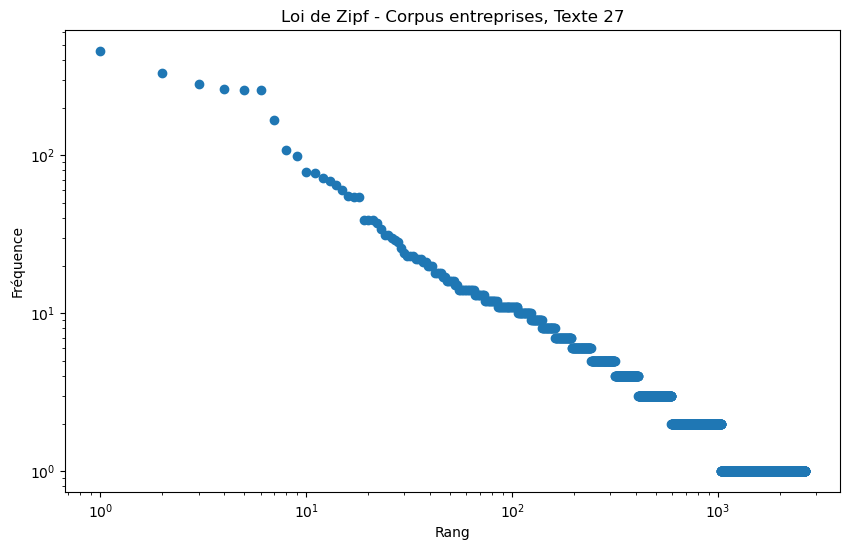

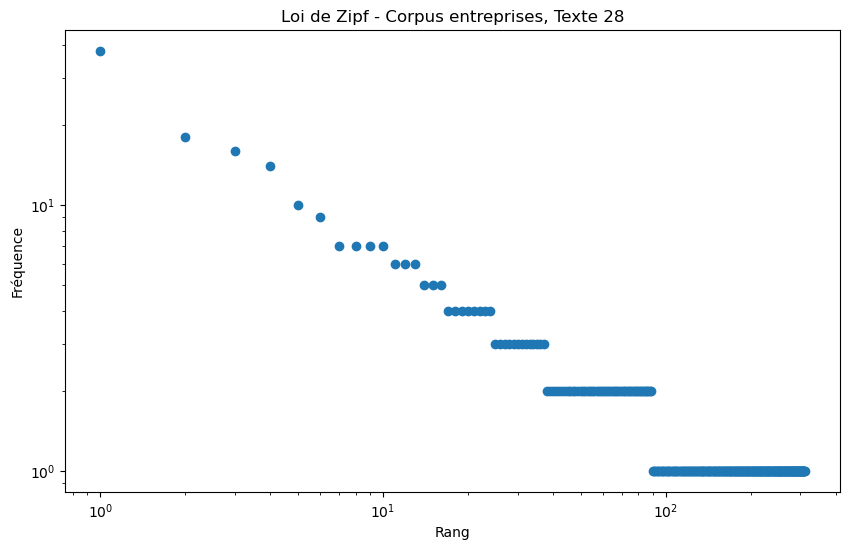

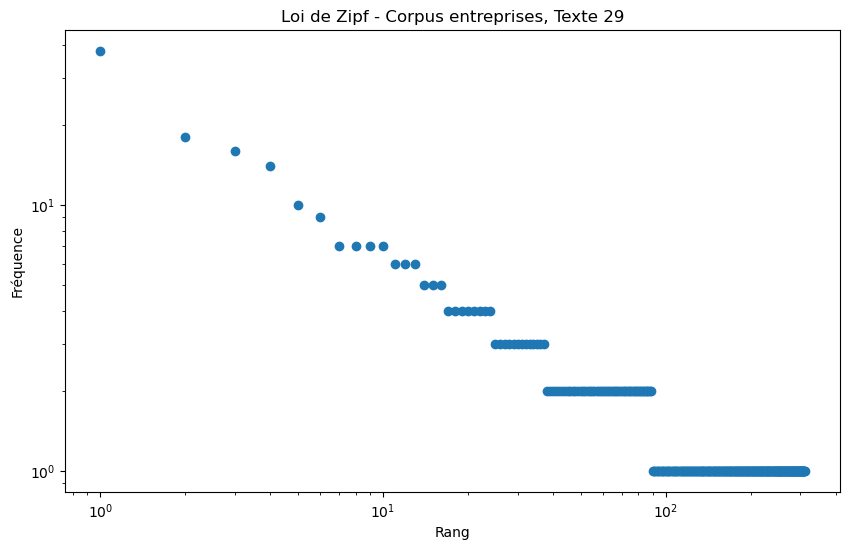

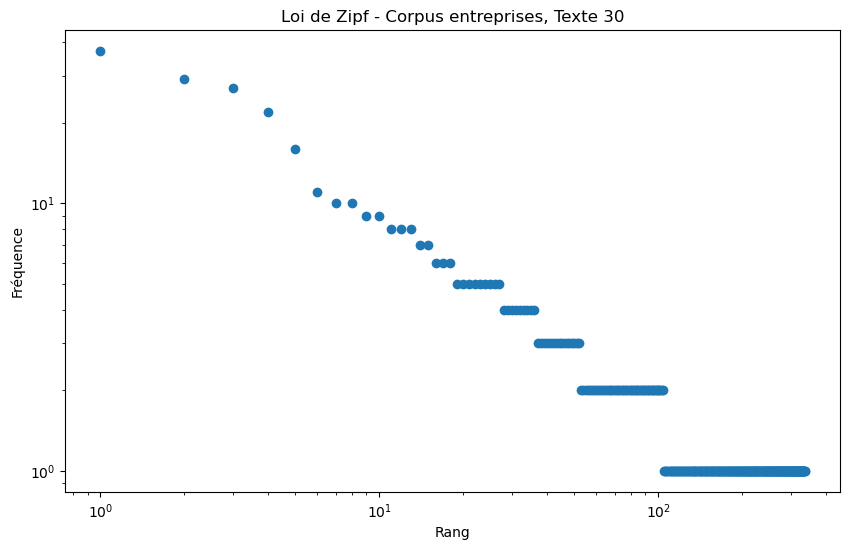

In [11]:
def plot_zipf_law(text:str, corpus:str, text_index:int) -> None:
    """
    Cette fonction analyse le contenu textuel d'un corpus et afficher les graphes de la loi zipf.

    Args:
        text: Le texte brut d'un document du corpus.
        corpus: Le corpus auquel le document appartien, un choix entre "fruits" et "entreprises".
        text_index: l'index du document dans le corpus.

    Returns:
        None
    """
    # Tokenisation des mots
    words = nltk.word_tokenize(text.lower())

    # Filtrage des mots non pertinents (ponctuation, etc.)
    words = [word for word in words if word.isalnum()]

    # Calcul des fréquences des mots
    word_freq = Counter(words)

    # Tri des mots par fréquence décroissante
    freq_list = word_freq.most_common()

    # Extraction des rangs et des fréquences
    ranks = list(range(1, len(freq_list) + 1))
    frequencies = [freq for _, freq in freq_list]

    # Visualisation des résultats
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker='o', linestyle='none')
    plt.title(f"Loi de Zipf - Corpus {corpus}, Texte {text_index + 1}")
    plt.xlabel("Rang")
    plt.ylabel("Fréquence")
    plt.show()
    
    return None

# Traiter chaque texte dans la première liste
for i, text in enumerate(corpus_fruits):
    plot_zipf_law(text, 'fruits', i)

# Traiter chaque texte dans la deuxième liste
for i, text in enumerate(corpus_companies):
    plot_zipf_law(text, 'entreprises', i)

# Fonctions pour la détection des NER tags

In [12]:
def get_ner_regexp(sent: str) -> list:
    """
    Cette fonction prend une phrase en tant que corpus et retourne une liste de tags NER pour chaque token.

    Args:
        sent (str): Une phrase sous forme de chaîne de caractères.

    Returns:
        list: Une liste de tags NER pour chaque token de la phrase.

    Correspondances des chiffres et les NER tags:
        dict_ner_tags = {
            1: 'B-I-PER',  # Personnes
            2: 'B-I-ORG',  # Organisations
            3: 'B-I-LOC'   # Lieux
            0: Pas de tag
        }
    Les patterns de regexp sont obtenus dans les liens suivants : 
    Pour les personnes : https://stackoverflow.com/a/2385967
    Pour les organisations : https://stackoverflow.com/a/6505086
    Pour les localisations : https://stackoverflow.com/a/25677072
    """
    list_ner_tags = []

    # Définition des motifs de correspondance pour chaque type d'entité
    patterns = {
        '1': r"\b^[a-zA-Z ,.\'-]+$\b",  # Personnes
        '2': r"\b^[A-Z]([a-zA-Z0-9]|[- @\.#&!])*$\b",  # Organisations
        '3': r"\b^([a-zA-Z\u0080-\u024F]+(?:. |-| |'))*[a-zA-Z\u0080-\u024F]*$\b"  # Lieux
    }

    for token in sent:
        entities = set()
        # Recherche des entités dans le texte
        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, token.text)
            for match in matches:
                # Ce qui commence par un espace n'est pas pertinent
                if not match.startswith(' '):
                    entities.add(int(entity_type))
        # Si aucune entité n'est détectée, on attribue 0 comme tag NER
        if len(entities) == 0:
            entities.add(0)
        # Ajoute tous les tags détectés pour un token dans la liste de tags
        list_ner_tags.append(list(entities))

    return list_ner_tags

def get_ner_spacy(doc: spacy.tokens.doc.Doc) -> list:
    """
    Cette fonction retourne une liste de tags NER pour tous les tokens d'une phrase analysée par Spacy.

    Args:
        doc (spacy.tokens.doc.Doc): Une phrase déjà analysée et analysée par Spacy.

    Returns:
        list: Une liste de tags NER pour chaque token de la phrase.

    Correspondances entre les chiffres et les tags NER :
        dict_ner_tags = {
            1: 'B-I-PER',  # Personnes
            2: 'B-I-ORG',  # Organisations
            3: 'B-I-LOC'   # Lieux
            0: Pas de tag
        }
    """
    # Initialiser une liste de tags NER vide
    list_ner_tags = []

    # Parcourir toutes les entités nommées de la phrase
    for ent in doc.ents:
        # Initialiser un tag NER vide pour chaque token
        ner_tag = 0
        # Associer un tag NER en fonction de l'entité nommée détectée par Spacy
        if ent.label_ == "PERSON":
            ner_tag = 1
        elif ent.label_ == "ORG":
            ner_tag = 2
        elif ent.label_ == "GPE":
            ner_tag = 3
        list_ner_tags.append(ner_tag)

    return list_ner_tags

def get_analyze(corpus: str, regexp: bool) -> list:
    """
    Cette fonction prend un corpus nettoyé et retourne une liste de dictionnaires.
    Chaque dictionnaire représente une phrase analysée avec tous les tokens et tous les tags analysés.
    Les NER tags sont trouvés soit avec les expressions régulières, soit avec Spacy.

    Args:
        corpus (str): Le corpus nettoyé sans balises et prétraité.
        regexp (bool): True pour utiliser les patterns de regex, False pour utiliser Spacy.

    Returns:
        list: Une liste de dictionnaires représentant chaque phrase analysée.
              Chaque dictionnaire contient les tokens et les tags NER de la phrase.

    Paramètres:
    - corpus : Un string, le corpus nettoyé et prétraité.
    - regexp : True pour utiliser les patterns de regex, False pour utiliser Spacy.
    """

    # Chargement du modèle Spacy pour la tokenisation
    nlp = spacy.load("en_core_web_sm")

    # Utilisation de NLTK pour segmenter le corpus en phrases
    list_sents = sent_tokenize(corpus)

    # Initialisation des listes pour stocker les phrases analysées et les tokens
    list_sents_nlp = []
    list_tokens = []

    # Analyse de chaque phrase avec Spacy
    for sent in list_sents:
        sent_nlp = nlp(sent)
        list_sents_nlp.append(sent_nlp)

    # Parcours de chaque phrase analysée par Spacy
    for i, sent in enumerate(list_sents_nlp):
        list_tokens.append([])  # Initialisation de la liste des tokens pour chaque phrase

        # Parcours des tokens de la phrase
        for tok in sent:
            # Initialisation d'un objet Token avec son indice, sa forme et un tag NER de 0
            token = Token(int(tok.i), str(tok.text), [0])
            list_tokens[-1].append(token)  # Ajout du token à la liste des tokens de la phrase

        # Récupération des tags NER avec les patterns si regexp est True, sinon avec Spacy
        if regexp:
            for ii, ner in enumerate(get_ner_regexp(sent)):
                if ner != 0:
                    list_tokens[i][ii].ner_tag = ner
        else:
            for ii, ner in enumerate(get_ner_spacy(sent)):
                if ner != 0:
                    list_tokens[i][ii].ner_tag = [ner]
    
    # Construction de la liste de sortie contenant les dictionnaires représentant chaque phrase analysée
    list_dict_results = []
    for i, sent in enumerate(list_tokens):
        dict_results = {}  # Initialisation du dictionnaire pour une phrase
        list_formes = [tok.forme for tok in sent]  # Formes de tous les tokens
        list_ners = [tok.ner_tag for tok in sent]  # Tags NER de tous les tokens
        dict_results['id'] = str(i)  # Indice de la phrase
        dict_results['tokens'] = list_formes  # Formes des tokens
        dict_results['ner_tags'] = list_ners  # Tags NER des tokens
        list_dict_results.append(dict_results)  # Ajout du dictionnaire à la liste de sortie
    
    return list_dict_results

def get_results(data: list, objet: str, regexp: bool) -> None:
    """
    Cette fonction prend une liste de données, qui peut être une liste de corpus de sites sur les fruits ou sur les entreprises.
    Elle récupère le contenu de chaque URL, trouve les NER tags avec Spacy ou avec les expressions régulières, puis écrit les résultats dans des fichiers TSV et des fichiers pickle externes.

    Args:
        data (list): Une liste de corpus de sites web.
        objet (str): 'fruit' pour analyser les sites sur les fruits, sinon pour analyser les sites sur les entreprises.
        regexp (bool): True pour utiliser les expressions régulières pour trouver les NER tags, False pour utiliser Spacy.

    Parameters:
        - data: Une liste de corpus de sites web.
        - objet: 'fruit' ou autre. Utilisez 'fruit' pour analyser les sites sur les fruits, sinon pour analyser les sites sur les entreprises.
        - regexp: True pour utiliser les expressions régulières pour trouver les NER tags, False pour utiliser Spacy.
    """

    list_corpus = []
    for corpus in data:
        # Obtenir les résultats d'analyse pour chaque corpus
        list_dict_results = get_analyze(corpus, regexp)
        list_corpus.append(list_dict_results)

    all_corpus = []
    for i, corpus in enumerate(list_corpus):
        # Obtenir le nombre total de tokens dans chaque corpus
        length = sum([len(c['tokens']) for c in corpus])
        all_corpus.append(Result(i+1, corpus, length))

    # Déterminer le chemin de sortie en fonction de l'objet ('fruit' ou autre)
    if objet == "fruit":
        output_path = 'tableau_output_fruits'
    else:
        output_path = 'tableau_output_companies'
    
    # Sauvegarder les résultats sous forme de fichiers TSV et de fichiers pickle
    if regexp:
        # Si regexp est True, utiliser les expressions régulières pour trouver les NER tags
        for i, corpus in enumerate(all_corpus):
            with open("../../results/tableaux_pred/"+str(i+1)+"_"+output_path+".tsv", 'w') as csvfile:
                writer = csv.writer(csvfile, delimiter="\t")
                writer.writerow(corpus.datas[0].keys())
                for sent in corpus.datas:
                    writer.writerow([sent['id'], sent['tokens'], sent['ner_tags']])
            with open("../../results/results_pred/"+str(i+1)+"_"+output_path+".pkl", 'wb') as pickle_file:
                pickle.dump(corpus, pickle_file)
    else:
        # Si regexp est False, utiliser Spacy pour trouver les NER tags
        for i, corpus in enumerate(all_corpus):
            with open("../../results/tableaux_ref/"+str(i+1)+"_"+output_path+".tsv", 'w') as csvfile:
                writer = csv.writer(csvfile, delimiter="\t")
                writer.writerow(corpus.datas[0].keys())
                for sent in corpus.datas:
                    writer.writerow([sent['id'], sent['tokens'], sent['ner_tags']])
            with open("../../results/results_ref/"+str(i+1)+"_"+output_path+".pkl", 'wb') as pickle_file:
                pickle.dump(corpus, pickle_file)  

    return all_corpus

# Résultats de prédiction

In [13]:
# Génération des résultats de prédiction pour les fruits et pour les entreprises.
results_fruits_pred = get_results(train_fruits, 'fruit', True)
results_companies_pred = get_results(train_companies, 'companies', True)

## Mettre les nombres de tokens de chaque corpus et leurs nombres de NER tags dans des dictionnaires

In [14]:
# Initialisation des dictionnaires pour stocker le nombre de NER tags par nombre de tokens
len_tags_fruits: dict = defaultdict(int)
len_tags_companies: dict = defaultdict(int)

# Calcul du nombre de NER tags pour chaque corpus de fruits
for c in results_fruits_pred:
    nb_tags = 0
    # Parcours de chaque phrase analysée dans le corpus
    for sent in c.datas:
        # Parcours des tags de chaque token dans la phrase
        for tags in sent:
            if tags != [0]:
                nb_tags += len(tags)
    len_tags_fruits[c.length] = nb_tags

# Calcul du nombre de NER tags pour chaque corpus d'entreprises
for c in results_companies_pred:
    nb_tags = 0
    # Parcours de chaque phrase analysée dans le corpus
    for sent in c.datas:
        # Parcours des tags de chaque token dans la phrase
        for tags in sent:
            if tags != [0]:
                nb_tags += len(tags)
    len_tags_companies[c.length] = nb_tags
    
# Affichage des résultats pour les fruits
print("Pour les fruits : ")
for k, v in len_tags_fruits.items():
    print("\tLe nombre de tokens :", k, "\tLe nombre de NER tags :", v)

# Affichage des résultats pour les entreprises
print("\nPour les entreprises : ")
for k, v in len_tags_companies.items():
    print("\tLe nombre de tokens :", k, "\tLe nombre de NER tags :", v)

Pour les fruits : 
	Le nombre de tokens : 3769 	Le nombre de NER tags : 2256
	Le nombre de tokens : 3149 	Le nombre de NER tags : 2416
	Le nombre de tokens : 6509 	Le nombre de NER tags : 3968
	Le nombre de tokens : 2404 	Le nombre de NER tags : 1456
	Le nombre de tokens : 4395 	Le nombre de NER tags : 2736
	Le nombre de tokens : 1479 	Le nombre de NER tags : 1056
	Le nombre de tokens : 1683 	Le nombre de NER tags : 1248
	Le nombre de tokens : 3898 	Le nombre de NER tags : 2640
	Le nombre de tokens : 5863 	Le nombre de NER tags : 3648
	Le nombre de tokens : 7292 	Le nombre de NER tags : 4560
	Le nombre de tokens : 2202 	Le nombre de NER tags : 1264
	Le nombre de tokens : 3092 	Le nombre de NER tags : 1776
	Le nombre de tokens : 2361 	Le nombre de NER tags : 1312
	Le nombre de tokens : 2668 	Le nombre de NER tags : 1616
	Le nombre de tokens : 1232 	Le nombre de NER tags : 704

Pour les entreprises : 
	Le nombre de tokens : 13799 	Le nombre de NER tags : 6848
	Le nombre de tokens : 1802 

# Visualisation des résultats en graphes

## Corrélation entre nombre de tokens et nombre de NER tags avec le calcul de la P-Value

Corrélation de Pearson pour les fruits : 0.9895195395730051
P Value pour les fruits : 2.5996890154821538e-12
Corrélation de Pearson pour les entreprises : 0.9901214502595521
P Value pour les entreprises : 1.31352994823235e-11


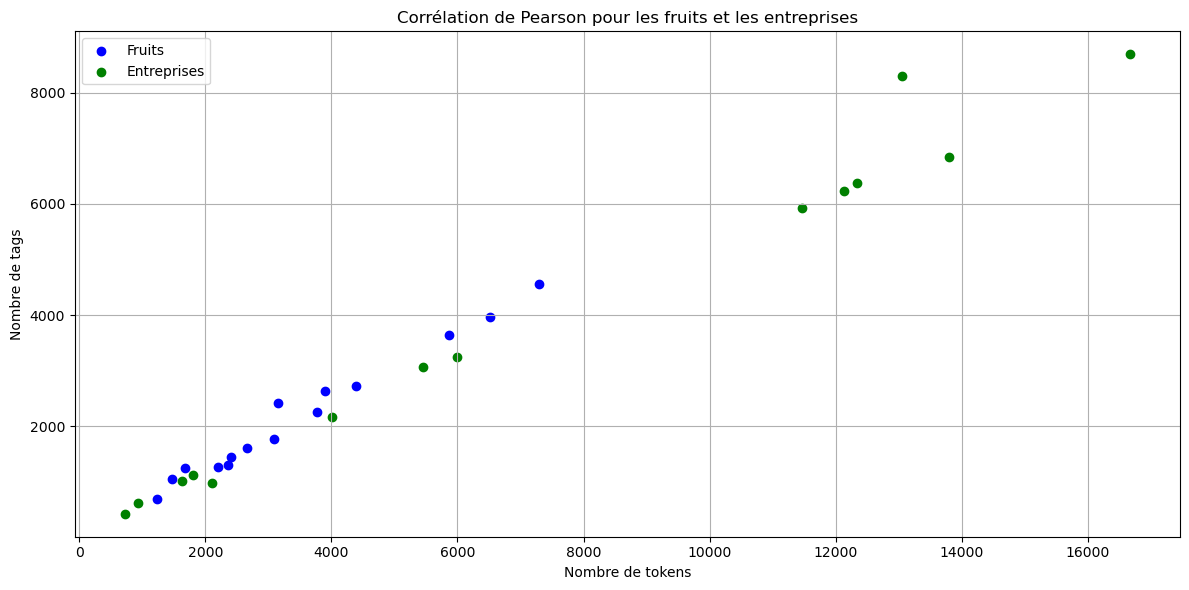

In [15]:
# Obtenir les clés et les valeurs des deux dictionnaires
cles_fruits = np.array(list(len_tags_fruits.keys()))
valeurs_fruits = np.array(list(len_tags_fruits.values()))

cles_companies = np.array(list(len_tags_companies.keys()))
valeurs_companies = np.array(list(len_tags_companies.values()))

# Calculer la corrélation de Pearson et la valeur P pour les clés et les valeurs
corr_fruits, p_value_fruits = scipy.stats.pearsonr(cles_fruits, valeurs_fruits)
corr_companies, p_value_companies = scipy.stats.pearsonr(cles_companies, valeurs_companies)

# Afficher les résultats
print("Corrélation de Pearson pour les fruits :", corr_fruits)
print("P Value pour les fruits :", p_value_fruits)

print("Corrélation de Pearson pour les entreprises :", corr_companies)
print("P Value pour les entreprises :", p_value_companies)

# Visualisation avec un nuage de points
plt.figure(figsize=(12, 6))


plt.scatter(cles_fruits, valeurs_fruits, color='blue', label='Fruits')
plt.scatter(cles_companies, valeurs_companies, color='green', label='Entreprises')

plt.xlabel("Nombre de tokens")
plt.ylabel("Nombre de tags")
plt.title("Corrélation de Pearson pour les fruits et les entreprises")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Ces résultats indiquent une forte corrélation positive entre le nombre de tokens et le nombre de NER tags à la fois pour les fruits et pour les entreprises.

Pour les fruits, la corrélation de Pearson est d'environ 0.9895, ce qui indique une forte corrélation positive presque parfaite entre le nombre de tokens et le nombre de NER tags. Cependant, la p-value associée est extrêmement faible (2.5996890154821538e-12), largement en dessous du seuil par défaut 0.05. Cela suggère qu'il est très improbable d'observer une corrélation aussi forte entre ces deux variables dans un échantillon aléatoire s'il n'y avait pas de relation réelle entre elles.

Pour les entreprises, la corrélation de Pearson est un peu supérieure à celle des fruits, à environ 0.9901. Tout comme pour les fruits, la p-value est très faible (1.31352994823235e-11), ce qui renforce l'idée que la corrélation observée est très improbable.

# Concaténation du corpus de référence et des nouveaux corpus

## Ce bloc importe le corpus de référence puis le transforme en DataFrame

In [16]:
# Charger le dataset conll2003
dataset = load_dataset("conll2003")
dataset_reference = dataset['train']
tableau_reference = dataset_reference.to_pandas()

# Supprimer les colonnes "pos_tags" et "chunk_tags"
tableau_reference.drop(columns=["pos_tags", "chunk_tags"], inplace=True)

# Ajouter une colonne "indice_tableau" avec la valeur "tableau reference"
tableau_reference = tableau_reference.assign(indice_tableau="tableau reference")

# Convertir chaque objet de np.array dans "ner_tags" en une liste
tableau_reference['ner_tags'] = tableau_reference['ner_tags'].apply(lambda tags: [[nb] for nb in tags])

# Afficher le DataFrame après transformation
display(tableau_reference)


,id,tokens,ner_tags,indice_tableau
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[[3], [0], [7], [0], [0], [0], [7], [0], [0]]",tableau reference
1,1,"[Peter, Blackburn]","[[1], [2]]",tableau reference
2,2,"[BRUSSELS, 1996-08-22]","[[5], [0]]",tableau reference
3,3,"[The, European, Commission, said, on, Thursday...","[[0], [3], [4], [0], [0], [0], [0], [0], [0], ...",tableau reference
4,4,"[Germany, 's, representative, to, the, Europea...","[[5], [0], [0], [0], [0], [3], [4], [0], [0], ...",tableau reference
...,...,...,...,...
14036,14036,"[on, Friday, :]","[[0], [0], [0]]",tableau reference
14037,14037,"[Division, two]","[[0], [0]]",tableau reference
14038,14038,"[Plymouth, 2, Preston, 1]","[[3], [0], [3], [0]]",tableau reference
14039,14039,"[Division, three]","[[0], [0]]",tableau reference


## Pré-traiter les nouveaux corpus créés et les concatener avec le corpus de référence

In [17]:
def string_to_numpy_array(string_list: list) -> np.ndarray:
    """
    Convertit une liste de chaînes de caractères en tableau numpy.

    Cette fonction prend une liste de chaînes de caractères représentant des listes,
    puis transforme chaque élément de la liste en un tableau numpy.

    Args:
        string_list (list): Une colonne de DataFrame représentée sous forme de liste de chaînes de caractères.

    Returns:
        np.ndarray: Un tableau numpy contenant les données transformées.

    Parameters:
        - string_list (list): Une colonne de DataFrame à convertir en tableau numpy.
    """
    python_list = ast.literal_eval(string_list)
    numpy_array = np.array(python_list)
    return numpy_array

In [18]:
def pre_processing_tableau(tableau: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """
    Prétraitement d'un DataFrame contenant des corpus.

    Cette fonction prétraite les données du DataFrame en effectuant les opérations suivantes :
    - Convertit la colonne 'id' en chaînes de caractères.
    - Réinitialise l'index du DataFrame.

    Args:
        tableau (pd.core.frame.DataFrame): Le DataFrame à prétraiter.

    Returns:
        pd.core.frame.DataFrame: Le DataFrame prétraité.

    Parameters:
        - tableau (pd.core.frame.DataFrame): Le DataFrame contenant les corpus à prétraiter.
    """
    tableau['id'] = tableau['id'].astype(str)
    
    tableau.reset_index(drop=True, inplace=True)

    return tableau

In [19]:
# Définir le répertoire contenant les tableaux de prédiction
rep_tables = Path("../../results/tableaux_pred/")

# Liste pour stocker tous les DataFrames des tableaux
dfs_companies = []
dfs_fruits = []

# Parcourir les tableaux des companies
for idx, tableau in enumerate(rep_tables.glob("*companies*.tsv")):
    df = pd.read_csv(tableau, delimiter='\t')  # Lire le tableau TSV
    df['indice_tableau'] = f'companies {idx+1}'  # Ajouter une colonne pour l'indice du tableau
    dfs_companies.append(df)  # Ajouter le DataFrame à la liste

# La même chose pour les fruits
for idx, tableau in enumerate(rep_tables.glob("*fruits*.tsv")):
    df = pd.read_csv(tableau, delimiter='\t')  # Lire le tableau TSV
    df['indice_tableau'] = f'fruits {idx+1}'  # Ajouter une colonne pour l'indice du tableau
    dfs_fruits.append(df)  # Ajouter le DataFrame à la liste

# Concaténer tous les DataFrames dans un seul DataFrame
df_companies = pd.concat(dfs_companies, ignore_index=True)
df_companies['ner_tags'] = df_companies['ner_tags'].apply(lambda x: ast.literal_eval(x))
df_fruits = pd.concat(dfs_fruits, ignore_index=True)
df_fruits['ner_tags'] = df_fruits['ner_tags'].apply(lambda x: ast.literal_eval(x))

In [20]:
# Concaténation avec le corpus de référence
new_tableau = pd.concat([tableau_reference, df_companies, df_fruits], axis=0)

## Présentation du corpus concaténé

In [21]:
display(new_tableau)

,id,tokens,ner_tags,indice_tableau
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[[3], [0], [7], [0], [0], [0], [7], [0], [0]]",tableau reference
1,1,"[Peter, Blackburn]","[[1], [2]]",tableau reference
2,2,"[BRUSSELS, 1996-08-22]","[[5], [0]]",tableau reference
3,3,"[The, European, Commission, said, on, Thursday...","[[0], [3], [4], [0], [0], [0], [0], [0], [0], ...",tableau reference
4,4,"[Germany, 's, representative, to, the, Europea...","[[5], [0], [0], [0], [0], [3], [4], [0], [0], ...",tableau reference
...,...,...,...,...
3490,136,"['[', '86][87', ']', '\n', 'Some', 'pests', 't...","[[0], [0], [0], [0], [1, 2, 3], [1, 3], [1, 3]...",fruits 24
3491,137,"['[', '83', ']', '\n', 'Heart', '-', 'rot', 'i...","[[0], [0], [0], [0], [1, 2, 3], [0], [1, 3], [...",fruits 24
3492,138,"['The', 'disease', 'is', 'caused', 'by', 'Phyt...","[[1, 2, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1...",fruits 24
3493,139,"['Since', 'it', 'is', 'difficult', 'to', 'trea...","[[1, 2, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1...",fruits 24


# Comparer la fréquence des NER tags

Il y a au total 3 catégories de NER tags : 
- 1 : B-I-PER (PERSONNE, token du début de l'entité)
- 2 : B-I-ORG (PERSONNE, token à l'intérieur de l'entité)
- 3 : B-I-LOC (ORGANISATION, token du début de l'entité)

***Ici, nous calculons la fréquence de tags par catégorie dans les deux corpus***

In [22]:
def dict_ner(tableau: pd.core.frame.DataFrame) -> dict:
    """
    Génère un dictionnaire de la fréquence des NER tags par catégorie à partir d'un corpus de DataFrame.

    Cette fonction parcourt le DataFrame contenant les données du corpus et calcule la fréquence des NER tags
    pour chaque catégorie. Les NER tags sont représentés par des entiers.

    Args:
        tableau (pd.core.frame.DataFrame): Le corpus représenté sous forme de DataFrame.

    Returns:
        dict: Un dictionnaire contenant la fréquence des NER tags pour chaque catégorie.

    Parameters:
        - tableau (pd.core.frame.DataFrame): Le DataFrame représentant le corpus de données.
    """

    # Initialisation d'un dictionnaire pour stocker la fréquence des NER tags
    dict_ner = defaultdict(int)

    # Parcours de la colonne 'ner_tags' du DataFrame
    for ner in tableau['ner_tags']:
        # Parcours de tous les NER tags dans une phrase
        for tags in ner:
            # Si le tag n'est pas [0] (s'il existe)
            if tags != [0]:
                # Incrémentation du compteur pour ce tag dans le dictionnaire
                for tag in tags:
                    dict_ner[tag] += 1
                    
    # Tri du dictionnaire par ordre décroissant de fréquence
    dict_ner = dict(sorted(dict_ner.items(), key=lambda x: x[1], reverse=True))

    # Calcul du nombre total de tags non vides
    total_tags = sum(dict_ner.values())
    
    # Calcul de la fréquence de chaque NER tag en pourcentage avec deux chiffres après la virgule
    for tag, freq in dict_ner.items():
        dict_ner[tag] = round(freq / total_tags, 4)
        
    return dict_ner

## Présentation des fréquences des NER tags

In [23]:
dict_companies = dict(sorted(dict_ner(df_companies).items(), key=lambda x:x[0]))
dict_fruits = dict(sorted(dict_ner(df_fruits).items(), key=lambda x:x[0]))

print("companies :")
for k, v in dict_companies.items():
    print("\ttag :", k, "\tfréquence :", v)
    
print("fruits :")
for k, v in dict_fruits.items():
    print("\ttag :", k, "\tfréquence :", v)

companies :
	tag : 1 	fréquence : 0.4509
	tag : 2 	fréquence : 0.0981
	tag : 3 	fréquence : 0.451
fruits :
	tag : 1 	fréquence : 0.467
	tag : 2 	fréquence : 0.0649
	tag : 3 	fréquence : 0.468


## Remplacer les indices des NER tags par leurs vrais noms

In [24]:
dict_ner_tags = {'B-I-PER': 1, 'B-I-ORG': 2, 'B-I-LOC': 3}
dict_ner_tags = {v:k for k,v in dict_ner_tags.items()}

dict_companies = {dict_ner_tags[k]: v for k, v in dict_companies.items()}
dict_fruits = {dict_ner_tags[k]: v for k, v in dict_fruits.items()}

print("companies :")
for k, v in dict_companies.items():
    print("\ttag :", k, "\tfréquence :", v)
    
print("fruits :")
for k, v in dict_fruits.items():
    print("\ttag :", k, "\tfréquence :", v)

companies :
	tag : B-I-PER 	fréquence : 0.4509
	tag : B-I-ORG 	fréquence : 0.0981
	tag : B-I-LOC 	fréquence : 0.451
fruits :
	tag : B-I-PER 	fréquence : 0.467
	tag : B-I-ORG 	fréquence : 0.0649
	tag : B-I-LOC 	fréquence : 0.468


## Mettre les résultats des deux corpus en graphes de colonnes

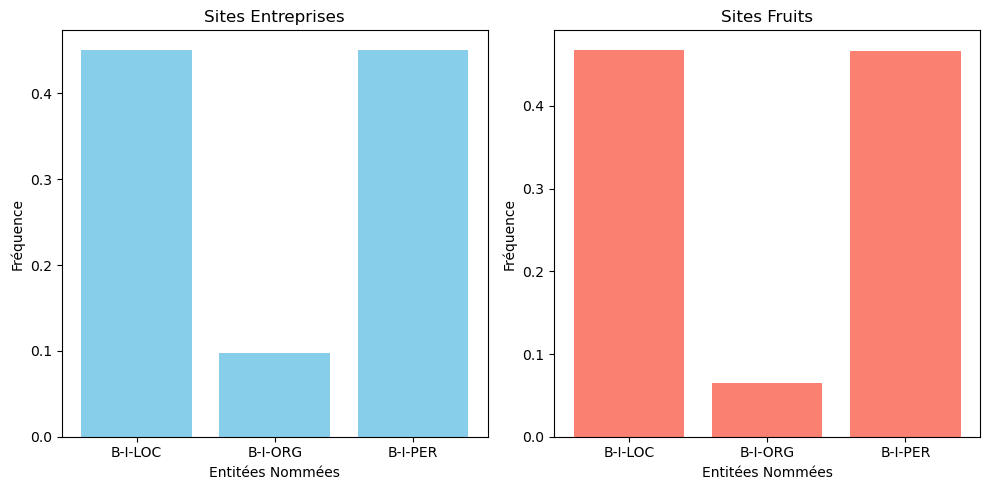

In [25]:
# Avoir l'ordre des barres sur l'axe X
keys_order = sorted(set(dict_companies.keys()))

# Graphe du résultat d'entreprises
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(keys_order)), [dict_companies.get(key, 0) for key in keys_order], color='skyblue', tick_label=keys_order)
plt.title('Sites Entreprises')
plt.xlabel('Entitées Nommées')
plt.ylabel('Fréquence')

# Graphe du résultat de fruits
plt.subplot(1, 2, 2)
plt.bar(range(len(keys_order)), [dict_fruits.get(key, 0) for key in keys_order], color='salmon', tick_label=keys_order)
plt.title('Sites Fruits')
plt.xlabel('Entitées Nommées')
plt.ylabel('Fréquence')

# Visualisation des résultats
plt.tight_layout()
plt.show()

***Dans les deux graphes, nous pouvons constater que le tag 'B-I-LOC' et le tag 'B-I-PER' sont plus importants que le tag 'B-I-ORG'. Cela signifie que les patterns de regexp détectent beaucoup d'entitées de localisation et de personnes mais très peu d'entités d'organisation.***

## Visualisation des deux graphes ensemble par catégorie avec les valeurs

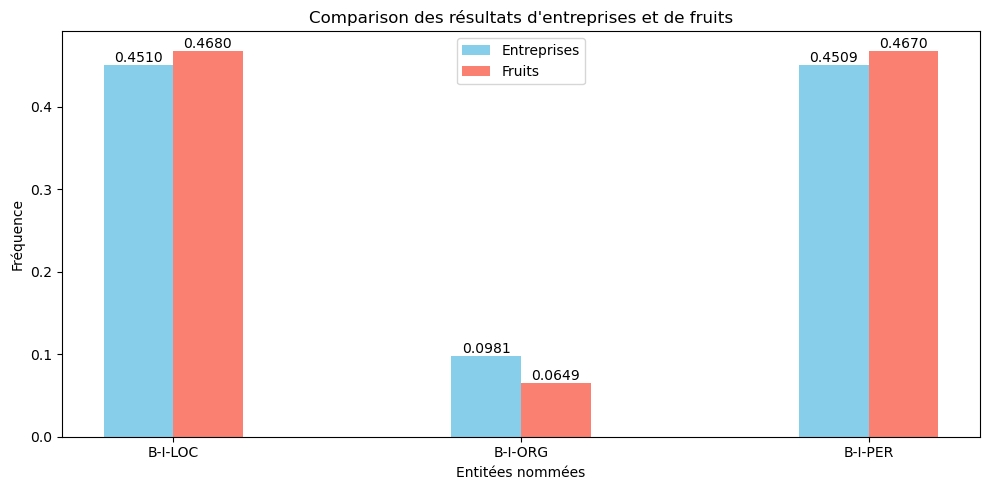

In [26]:
# Les valeurs des deux dictionnaires dans le même ordre
companies_values = [dict_companies.get(key, 0) for key in keys_order]
fruits_values = [dict_fruits.get(key, 0) for key in keys_order]

# Positions et Largeur des barres sur l'axe X
x = np.arange(len(keys_order))
width = 0.2

# Création du graphique à barres groupées
plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - width/2, companies_values, width, label='Entreprises', color='skyblue')
bars2 = plt.bar(x + width/2, fruits_values, width, label='Fruits', color='salmon')

# Afficher les valeurs au-dessus de chaque barre
for b1, b2 in zip(bars1, bars2):
    h1 = b1.get_height()
    h2 = b2.get_height()
    plt.text(b1.get_x() + b1.get_width() / 2, h1, '{:.4f}'.format(h1), ha='center', va='bottom')
    plt.text(b2.get_x() + b2.get_width() / 2, h2, '{:.4f}'.format(h2), ha='center', va='bottom')

# Noms axes et titre et légende
plt.xlabel('Entitées nommées')
plt.ylabel('Fréquence')
plt.title("Comparison des résultats d'entreprises et de fruits")
plt.xticks(x, keys_order)
plt.legend()

# Visualisation du graphe
plt.tight_layout()
plt.show()

***Depuis ce graphe, nous pouvons constater que le corpus d'entreprises contient beaucoup plus d'entitées d'organisation que le corpus de fruits. En revanche, les entités de personnes et de localisation sont légèrement plus nombreux dans les corpus de fruits que les corpus d'entreprises.***

# Évaluations

## Résultats ***y*** avec le Spacy
***Ici, on analyse les NER tags avec Spacy afin de fournir un groupe de référence pour l'évaluation des résultats générés par les patterns de regexp***

In [27]:
# Génération des résultats de référence pour les fruits et pour les entreprises.
results_fruits_y = get_results(train_fruits, 'fruit', 0)
results_companies_y = get_results(train_companies, 'companies', 0)

## Récupérer les résultats de référence et de prédiction sauvegardés en fichiers pickle

In [28]:
# Mettre les file path des fichiers pickle de prédiction et de référence dans deux listes
path_results_pred = []
path_results_ref = []
for p1,p2 in zip(Path("../../results/results_pred").iterdir(), Path("../../results/results_ref").iterdir()):
    if p1.suffix == '.pkl':
        path_results_pred.append(str(p1))
    if p2.suffix == '.pkl':
        path_results_ref.append(str(p2))

# Mettre les résultats de prédiction et de référence dans deux listes
all_results_pred = []
all_results_ref = []
for c1, c2 in zip(path_results_pred, path_results_ref):
    with open(c1, 'rb') as pickle_file:
        corpus = pickle.load(pickle_file)
        all_results_pred.append(corpus)
    with open(c2, 'rb') as pickle_file:
        corpus = pickle.load(pickle_file)
        all_results_ref.append(corpus)

# Trier les résultats selon leur ID
all_results_pred = list(sorted(all_results_pred, key=lambda x:x.id))
all_results_ref = list(sorted(all_results_ref, key=lambda x:x.id))

## Précision, rappel et f-mesure

In [29]:
def metriques(all_results_ref:list, all_results_pred:list) -> float:
    """
    Calcule les métriques de précision, rappel et F-mesure pour des résultats de référence et des résultats de prédiction.

    Args:
        all_results_ref (list): Liste des résultats de référence.
        all_results_pred (list): Liste des résultats de prédiction.

    Returns:
        float: La moyenne des précisions.
        float: La moyenne des rappels.
        float: La moyenne des F-mesures.
    """

    mean_precisionS = []
    mean_rappelS = []
    mean_f_mesureS = []
    
    # Parcours des résultats de référence et des résultats de prédiction
    for rlt_r, rlt_pred in zip(all_results_ref, all_results_pred):
        
        ref = rlt_r.datas
        pred = rlt_pred.datas

        ner_tags_ref = []
        ner_tags_pred = []
        # Extraction des NER tags pour les résultats de référence
        for i in ref:
            for tag in i['ner_tags']:
                ner_tags_ref.append(tag)
        # Extraction des NER tags pour les résultats de prédiction
        for i in pred:
            for tag in i['ner_tags']:
                ner_tags_pred.append(tag)
        
        # Calcul des précisions, rappels et F-mesures
        total_predictions = 0
        total_references = len(ner_tags_ref)
        compte = 0
        for p, r in zip(ner_tags_pred, ner_tags_ref):
            total_predictions += len(p)
            for t in p:
                if t in r:
                    compte += 1
        precision = compte / total_predictions if total_predictions != 0 else 0
        rappel = compte / total_references if total_references != 0 else 0
        mean_precisionS.append(precision)
        mean_rappelS.append(rappel)
        try:
            mean_f_mesureS.append((2 * precision * rappel) / (precision + rappel))
        except ZeroDivisionError:
            mean_f_mesureS.append(0)
            continue
    
    # Calcul des moyennes globales de précision, rappel et F-mesure sur tous les résultats
    return sum(mean_precisionS) / len(mean_precisionS), sum(mean_rappelS) / len(mean_rappelS), sum(mean_f_mesureS) / len(mean_f_mesureS)

In [30]:
mean_precision, mean_rappel, mean_f_mesure = metriques(all_results_ref, all_results_pred)

print("Les NER tags détectés avec les patterns de regexp par rapport au Spacy :")
print("La précision moyenne est :", round(mean_precision, 3))
print("Le rappel moyen est :", round(mean_rappel, 3))
print("Le score moyen de la f-mesure est :", round(mean_f_mesure, 3))

Les NER tags détectés avec les patterns de regexp par rapport au Spacy :
La précision moyenne est : 0.134
Le rappel moyen est : 0.253
Le score moyen de la f-mesure est : 0.176


Selon les résultats, nous pouvons constater que les NER tags détectés avec les patterns de regexp ont une performance globale inférieure à ceux détectés par Spacy, qui sont considérés ici comme les résultats de référence.

La précision moyenne de 0.134 signifie que seulement environ 13% des entités identifiées par les patterns de regexp sont correctes par rapport à celles identifiées par Spacy.
Le rappel moyen de 0.253 indique que les patterns de regexp ont réussi à détecter environ 25% des entités présentes dans les résultats de référence.
Le score moyen de la f-mesure de 0.176 montre une mesure globale de précision et de rappel, ce qui signifie que le modèle basé sur les patterns de regexp ne réussit pas à atteindre un bon équilibre entre la précision et le rappel.

En bref, ces résultats suggèrent que les patterns de regexp ne parviennent pas à détecter avec précision les NER tags par rapport au Spacy. De plus, étant donné que les patterns de regexp fournissent souvent plusieurs NER tags pour un token, cette méthode est donc très peu efficace. 